In [2]:
from matplotlib import pyplot as plt
from keras.datasets import fashion_mnist
import numpy as np
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
import math
from typing import List
from tqdm import tqdm

# Import cupy for gpu acceleration
# Please use GPU to reproduce our experiment
import cupy as cp
cp.random.seed(913)


In [3]:
cp.cuda.runtime.getDevice()

0

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


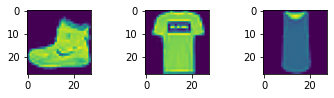

In [90]:
# load dataset
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

for i in range(3):
	# define subplot
	plt.subplot(330 + 1 +i )
	# plot raw pixel data
	plt.imshow(trainX[i])
 
# Print the data size of the training/testing sets
print(f'Train: X={trainX.shape}, y={trainy.shape}')
print(f'Test: X={testX.shape}, y={testy.shape}')

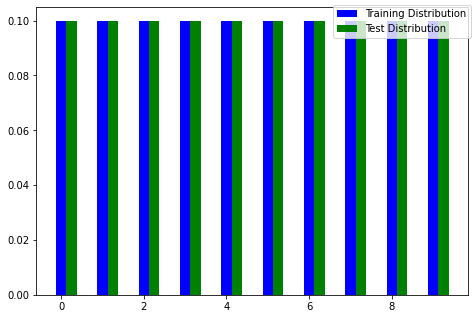

In [5]:
# Visualize the distribution of the dataset
distri_train= np.zeros(10)
for label in trainy:
  distri_train[label]+= 1
distri_train/= len(trainy)

distri_test= np.zeros(10)
for label in testy:
  distri_test[label]+= 1
distri_test/= len(testy)
xx= np.arange(10)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(xx + 0.00, distri_train, color = 'b', width = 0.25, label= 'Training Distribution')
ax.bar(xx + 0.25, distri_test, color = 'g', width = 0.25, label= 'Test Distribution')
fig.legend()

In [6]:
print(trainX[0].shape[0])
print(testX.shape)

28
(10000, 28, 28)


In [91]:
# Vectorize the dataset; Transform the data type into float; Normalize the dataset
trainX= trainX.astype('float32')/ 255.0
testX= testX.astype('float32')/ 255.0

trainX = np.expand_dims(trainX, axis=3)
testX = np.expand_dims(testX, axis=3)
print(trainX.shape)

vec_trainX= trainX.reshape((trainX.shape[0] ,trainX[0].shape[0]* trainX[0].shape[1]))
vec_testX= testX.reshape((testX.shape[0] ,testX[0].shape[0]* testX[0].shape[1]))
print(vec_trainX.shape)
print(vec_testX.shape)

vec_trainX= cp.asarray(vec_trainX)
vec_testX= cp.asarray(vec_testX)
testy= cp.asarray(testy)
trainy= cp.asarray(trainy)

vec_validX= vec_testX[:2000]
vec_testX= vec_testX[2000:]
validX= testX[:2000]
testX= testX[2000:]

(60000, 28, 28, 1)
(60000, 784)
(10000, 784)


In [92]:
# Transform the labels into one-hot encoding
#print(len(trainy))
print(trainy)
oh_trainy= cp.zeros((len(trainy), 10))
oh_testy= cp.zeros((len(testy), 10))
for idx, label in enumerate(trainy):
  oh_trainy[idx, label]= 1
for idx, label in enumerate(testy):
  oh_testy[idx, label]= 1

[9 0 0 ... 3 0 5]


In [94]:
oh_trainy= cp.asarray(oh_trainy)
oh_testy= cp.asarray(oh_testy)

oh_validy= oh_testy[:2000]
oh_testy= oh_testy[2000:]


In [98]:
validX.shape

(2000, 28, 28, 1)

In [95]:
validy= testy[:2000]
testy= testy[2000:]

In [10]:
print(trainy[0], oh_trainy[0])
print(testy[150], oh_testy[150])

9 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
4 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


In [11]:
n_features=vec_trainX.shape[1]
print(n_features)

784


In [12]:
with cp.cuda.Device(0):
  # Model Construction
  class NeuralNetLayer:
      def __init__(self):
          self.gradient = None
          self.parameters = None
          
      def forward(self, x):
          raise NotImplementedError

      def backward(self, gradient):
          raise NotImplementedError

In [13]:
with cp.cuda.Device(0):
  class LinearLayer(NeuralNetLayer):
      def __init__(self, input_size, output_size):
          super().__init__()
          self.ni = input_size
          self.no = output_size
          self.w = 0.05*cp.random.randn(output_size, input_size)
          self.b = 0.05*cp.random.randn(output_size)
          self.w= cp.asarray(self.w)
          self.b= cp.asarray(self.b)
          self.cur_input = None
          self.parameters = [self.w, self.b]

      def forward(self, x):
          #print(self.w)
          self.cur_input = x
          return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

      def backward(self, gradient):
          assert self.cur_input is not None, "Must call forward before backward"
          #dw = gradient.dot(self.cur_input)
          dw = cp.asarray(gradient[:, :, None] @ self.cur_input[:, None, :])
          db = cp.asarray(gradient)
          self.gradient = [dw, db]
          #print(self.gradient)
          return gradient.dot(self.w)

In [14]:
with cp.cuda.Device(0):
  class ReLULayer(NeuralNetLayer):
      def __init__(self):
          super().__init__()
          
      def forward(self, x):
          self.gradient = cp.where(x > 0, 1.0, 0.0)
          return cp.maximum(0, x)

      def backward(self, gradient):
          assert self.gradient is not None, "Must call forward before backward"
          return gradient * self.gradient

In [15]:
with cp.cuda.Device(0):
  class LeakyReLULayer(NeuralNetLayer):
      def __init__(self,alpha):
          super().__init__()
          self.alpha = alpha
          
      def forward(self, x):
          tmp= cp.where(x > 0, 1.0, x)
          self.gradient = cp.where(tmp < 0, 0.1* tmp, tmp)
          return cp.maximum(0,x) + self.alpha*cp.minimum(0,x)

      def backward(self, gradient):
          assert self.gradient is not None, "Must call forward before backward"
          return gradient * self.gradient

In [16]:
with cp.cuda.Device(0):
  class TanhLayer(NeuralNetLayer):
      def __init__(self):
          super().__init__()
          
      def forward(self, x):
          self.gradient = 1 - cp.power(np.tanh(x),2)
          return cp.tanh(x)

      def backward(self, gradient):
          assert self.gradient is not None, "Must call forward before backward"
          return gradient * self.gradient

In [17]:
with cp.cuda.Device(0):
  class SoftmaxOutputLayer(NeuralNetLayer):
      def __init__(self):
          super().__init__()
          self.cur_probs = None

      def forward(self, x):
          exps = cp.exp(x)
          probs = exps / cp.sum(exps, axis=-1)[:, None]
          self.cur_probs = probs
          return probs

      def backward(self, target):
          assert self.cur_probs is not None, "Must call forward before backward"
          return self.cur_probs - target

In [18]:
with cp.cuda.Device(0):
  class Multi_layer_perceptron:
      def __init__(self, *args: List[NeuralNetLayer]):
          self.layers = args

      def forward(self, x):
          for layer in self.layers:
              x = layer.forward(x)
          return x

      def backward(self, target):
          for layer in self.layers[::-1]:
              target = layer.backward(target)

In [19]:
with cp.cuda.Device(0):
  class Optimizer:
      def __init__(self, net: Multi_layer_perceptron):
          self.net = net

      def step(self,reg_coef=0):
          for layer_idx, layer in enumerate(self.net.mlp.layers[::-1]):
              if layer.parameters is not None:
                  self.update(layer.parameters, layer.gradient, layer_idx, reg_coef)

      def update(self, params, gradient, layer_idx):
          raise NotImplementedError

  class GradientDescentOptimizer(Optimizer):
      def __init__(self, net: Multi_layer_perceptron, lr: float):
          super().__init__(net)
          self.lr = lr

      def update(self, params, gradient, layer_idx, reg_coef=0):
          for (p, g) in zip(params, gradient):
              gradient= g+ reg_coef* p   # we add the regularization term to the gradient before updating the new weight
              p-= self.lr * gradient.mean(axis=0)

  class Adam(Optimizer):
      def __init__(self, net: Multi_layer_perceptron, lr: float):
          super().__init__(net)
          self.lr = lr
          self.m= [0 for _ in range(len(self.net.mlp.layers))]
          self.s= [0 for _ in range(len(self.net.mlp.layers))]
          self.t= 0
          for idx, layer in enumerate(self.net.mlp.layers[::-1]):
              if layer.parameters is not None:
                  weight_shape= layer.parameters[0].shape
                  bias_shape= layer.parameters[1].shape
                  self.s[idx]= [cp.zeros(weight_shape), cp.zeros(bias_shape)]
                  self.m[idx]= [cp.zeros(weight_shape), cp.zeros(bias_shape)]

      def update(self, params, gradient, layer_idx, reg_coef=0, beta1= 0.8, beta2= 0.999,  eps=1e-8):
          self.t+= 1
          for idx, (p, g) in enumerate(zip(params, gradient)):
              gradient= g+ reg_coef* p   # we add the regularization term to the gradient before updating the new weight
              gradient= gradient.mean(axis=0)
              # m(t) = beta1 * m(t-1) + (1 - beta1) * g(t)
              self.m[layer_idx][idx] = beta1 * self.m[layer_idx][idx] + (1.0 - beta1) * gradient
              # s(t) = beta2 * s(t-1) + (1 - beta2) * g(t)^2
              self.s[layer_idx][idx] = beta2 * self.s[layer_idx][idx] + (1.0 - beta2) * gradient**2
              # mhat(t) = m(t) / (1 - beta1(t))
              mhat = self.m[layer_idx][idx] / (1.0 - beta1**(self.t))
              # shat(t) = s(t) / (1 - beta2(t))
              shat = self.s[layer_idx][idx] / (1.0 - beta2**(self.t))
              # x(t) = x(t-1) - alpha * mhat(t) / (sqrt(shat(t)) + eps)
              p-= self.lr* mhat/cp.sqrt(shat+ eps)
          

In [20]:
with cp.cuda.Device(0):
  def shuffle(data, label):
    
    # To Shuffle the instances
    indx = cp.random.permutation(data.shape[0])       

    # The order is training_data, training_label
    return data[indx[:]], label[indx[:]]

In [21]:
with cp.cuda.Device(0):
  class MLP:
    def __init__(self, units = [128,128], num_layers = 2, activation_fn = ReLULayer(), output_fn = SoftmaxOutputLayer(),initial_scale = 1.,regularization = 0):
      self.reg_alpha=regularization   # we strore the regularization coefficient
      
      if num_layers == 0:
        self.mlp = Multi_layer_perceptron(
            LinearLayer(n_features, 10),
            output_fn
        )
      if (num_layers == 1 and len(units) == 1):
        self.mlp = Multi_layer_perceptron(
          LinearLayer(n_features, units[0]),
          activation_fn,
          LinearLayer(units[0], 10),
          output_fn
        )
      if (num_layers == 2 and len(units) == 2):
        self.mlp = Multi_layer_perceptron(
          LinearLayer(n_features, units[0]),
          activation_fn,
          LinearLayer(units[0],units[1]),
          activation_fn,
          LinearLayer(units[1], 10),
          output_fn
        )

    def fit(self, optimizer: Optimizer, train_data_x, train_data_y, test_data_x, test_data_y, 
          batch_size, epochs, epsilon= 1e-7, evaluate= False):
      losses = []
      #labels = np.eye(10)[np.array(data_y)]
      #print(labels.shape)
      #data_x_per, data_y_per = shuffle(data_x, data_y)
      train_acc= []
      test_acc= []
      for j in range(epochs):
        data_x_per, data_y_per = shuffle(train_data_x, train_data_y)
        print(f'Epoch {j}')
        prev_loss= math.inf
        for i in tqdm(range(int(len(data_x_per)/batch_size))):
          batch_x, batch_y = data_x_per[i*batch_size: (i+1)*batch_size], data_y_per[i*batch_size: (i+1)*batch_size]
          #print(batch_x.shape)
          predictions = self.mlp.forward(batch_x)
          #print(predictions)
          #print(np.log(predictions))
          label_y = cp.eye(10)[cp.array(batch_y)]
          loss = -(label_y * cp.log(predictions)).sum(axis=-1).mean().item()
          losses.append(loss)
          self.mlp.backward(label_y)
          optimizer.step(self.reg_alpha)
          if abs(prev_loss- loss)< epsilon:
            prev_loss= 'stop'
            break
          else:
            prev_loss= loss # Monitor the changes in loss to decide when to stop
        if evaluate:
          y_predicted = cp.argmax(self.predict(train_data_x), axis=-1)
          train_acc.append(eval_acc(y_predicted, train_data_y))
          y_predicted = cp.argmax(self.predict(test_data_x), axis=-1)
          test_acc.append(eval_acc(y_predicted, test_data_y))
        if prev_loss== 'stop':
          break

      return train_acc, test_acc, losses
      
    def predict(self,X):
      return self.mlp.forward(X)

    def check_grad(self, X, y):
      cp.random.seed(913)
      
      grads= []
      for layer in self.mlp.layers[::-1]:
        if layer.parameters is not None:
            
            #print(layer.gradient[0].shape, target.shape)
            para= layer.parameters[0]
            tmp_val_list= []
            for i in range(len(para)):
              for j in range(len(para[i])):
                predictions = self.mlp.forward(X)
                label_y = cp.eye(10)[cp.array(y)]
                loss = -(label_y * cp.log(predictions)).sum(axis=-1).mean().item()
                self.mlp.backward(label_y) # Perform the unmodified forward and backward pass to get the correct gradients

                
                weight_grad= layer.gradient[0].mean(axis=0)[i, j].item()

                ep= cp.random.rand() * 1e-5

                


                para[i, j]+= ep

                predictions = self.mlp.forward(X)
                label_y = cp.eye(10)[cp.array(y)]
                plus_loss = -(label_y * cp.log(predictions)).sum(axis=-1).mean().item()
                self.mlp.backward(label_y) # Epsilon plus pass

                epsi_plus_gradient= layer.gradient[0].mean(axis=0)[i, j].item()


                para[i, j]-= 2*ep

                predictions = self.mlp.forward(X)
                label_y = cp.eye(10)[cp.array(y)]
                minus_loss = -(label_y * cp.log(predictions)).sum(axis=-1).mean().item()
                self.mlp.backward(label_y)

                

                epsi_minus_gradient= layer.gradient[0].mean(axis=0)[i, j].item()

                para[i, j]+= ep 
                
                delta_weight= ((plus_loss- minus_loss)/ (2* ep)). item()
                #print(weight_grad, epsi_plus_gradient, epsi_minus_gradient, delta_weight, type(delta_weight))
                if (weight_grad- delta_weight)== 0 or (weight_grad+ delta_weight)== 0:
                  continue
                val= (weight_grad- delta_weight)**2/ (weight_grad+ delta_weight)**2
                #print(epsi_plus_gradient, epsi_minus_gradient, delta_weight, val)
                tmp_val_list.append(val)

            grads.append(sum(tmp_val_list)/ len(tmp_val_list))



      return grads


In [22]:
with cp.cuda.Device(0):
  def eval_acc(pred_X, targets):
      counter= 0
      for i in range(len(targets)):
          counter+= 1 if pred_X[i] == targets[i] else 0
      return (counter/len(targets))

In [53]:
lr_list=[0.01,0.005,0.001]
leaky_lr_list=[0.005,0.001,0.0005]
tanh_lr_list=[0.005,0.001,0.0005]

# Gradients Perturbation Check


In [24]:
cp.random.seed(913)
mlp0 = MLP(num_layers=0)
mlp0.check_grad(vec_testX[:32], testy[:32])

[3.9507014358382836e-12]

In [25]:
cp.random.seed(913)
mlp1 = MLP(num_layers=1, units= [32])
mlp1.check_grad(vec_testX[:32], testy[:32])

[4.384225580035727e-15, 2.9809652012875505e-10]

# 0-layer

In [85]:
cp.random.seed(913)
testX_s, testy_s = shuffle(vec_testX, testy)
trainX_s, trainy_s = shuffle(vec_trainX, trainy)
validX_s, validy_s = shuffle(vec_validX, validy)

In [54]:
with cp.cuda.Device(0):
    cp.random.seed(913)
    testX_s, testy_s = shuffle(vec_testX, testy)
    trainX_s, trainy_s = shuffle(vec_trainX, trainy)
    final_valid= []
    accs_train=[]
    accs_test=[]
    for i in range(len(lr_list)):
        train_acc_tmp=[]
        test_acc_tmp=[]
        mlp0 = MLP(num_layers=0)
        opt = GradientDescentOptimizer(mlp0,lr_list[i])
        train_acc_tmp, test_acc_tmp, loss = mlp0.fit(opt,trainX_s,trainy_s,testX_s,testy_s,32,30, evaluate=True)
        y_predicted = cp.argmax(mlp0.predict(validX_s), axis=-1)
        final_valid.append(eval_acc(y_predicted, validy_s))
        accs_train.append(train_acc_tmp)
        accs_test.append(test_acc_tmp)

Epoch 0


100%|██████████| 1875/1875 [00:01<00:00, 1224.13it/s]


Epoch 1


100%|██████████| 1875/1875 [00:01<00:00, 1263.60it/s]


Epoch 2


100%|██████████| 1875/1875 [00:01<00:00, 1257.91it/s]


Epoch 3


100%|██████████| 1875/1875 [00:01<00:00, 1275.90it/s]


Epoch 4


100%|██████████| 1875/1875 [00:01<00:00, 1262.76it/s]


Epoch 5


100%|██████████| 1875/1875 [00:01<00:00, 1113.98it/s]


Epoch 6


100%|██████████| 1875/1875 [00:01<00:00, 1253.39it/s]


Epoch 7


100%|██████████| 1875/1875 [00:01<00:00, 1271.16it/s]


Epoch 8


100%|██████████| 1875/1875 [00:01<00:00, 1120.94it/s]


Epoch 9


100%|██████████| 1875/1875 [00:01<00:00, 1256.03it/s]


Epoch 10


100%|██████████| 1875/1875 [00:01<00:00, 1274.08it/s]


Epoch 11


100%|██████████| 1875/1875 [00:01<00:00, 1269.06it/s]


Epoch 12


100%|██████████| 1875/1875 [00:01<00:00, 1273.04it/s]


Epoch 13


100%|██████████| 1875/1875 [00:01<00:00, 1260.57it/s]


Epoch 14


100%|██████████| 1875/1875 [00:01<00:00, 1274.01it/s]


Epoch 15


100%|██████████| 1875/1875 [00:01<00:00, 1274.44it/s]


Epoch 16


100%|██████████| 1875/1875 [00:01<00:00, 1135.71it/s]


Epoch 17


100%|██████████| 1875/1875 [00:01<00:00, 1242.86it/s]


Epoch 18


100%|██████████| 1875/1875 [00:01<00:00, 1195.32it/s]


Epoch 19


100%|██████████| 1875/1875 [00:01<00:00, 1095.24it/s]


Epoch 20


100%|██████████| 1875/1875 [00:01<00:00, 1264.77it/s]


Epoch 21


100%|██████████| 1875/1875 [00:01<00:00, 939.01it/s] 


Epoch 22


100%|██████████| 1875/1875 [00:01<00:00, 1262.92it/s]


Epoch 23


100%|██████████| 1875/1875 [00:01<00:00, 1272.52it/s]


Epoch 24


100%|██████████| 1875/1875 [00:01<00:00, 1112.24it/s]


Epoch 25


100%|██████████| 1875/1875 [00:01<00:00, 1269.86it/s]


Epoch 26


100%|██████████| 1875/1875 [00:01<00:00, 1141.06it/s]


Epoch 27


100%|██████████| 1875/1875 [00:01<00:00, 1153.47it/s]


Epoch 28


100%|██████████| 1875/1875 [00:01<00:00, 1276.36it/s]


Epoch 29


100%|██████████| 1875/1875 [00:01<00:00, 1242.50it/s]


Epoch 0


100%|██████████| 1875/1875 [00:01<00:00, 1277.29it/s]


Epoch 1


100%|██████████| 1875/1875 [00:01<00:00, 1273.71it/s]


Epoch 2


100%|██████████| 1875/1875 [00:01<00:00, 1056.99it/s]


Epoch 3


100%|██████████| 1875/1875 [00:01<00:00, 1128.42it/s]


Epoch 4


100%|██████████| 1875/1875 [00:01<00:00, 1176.88it/s]


Epoch 5


100%|██████████| 1875/1875 [00:01<00:00, 1068.00it/s]


Epoch 6


100%|██████████| 1875/1875 [00:01<00:00, 1252.32it/s]


Epoch 7


100%|██████████| 1875/1875 [00:01<00:00, 1086.05it/s]


Epoch 8


100%|██████████| 1875/1875 [00:01<00:00, 1239.44it/s]


Epoch 9


100%|██████████| 1875/1875 [00:01<00:00, 1211.40it/s]


Epoch 10


100%|██████████| 1875/1875 [00:01<00:00, 1272.01it/s]


Epoch 11


100%|██████████| 1875/1875 [00:01<00:00, 1275.12it/s]


Epoch 12


100%|██████████| 1875/1875 [00:01<00:00, 1271.03it/s]


Epoch 13


100%|██████████| 1875/1875 [00:01<00:00, 1224.94it/s]


Epoch 14


100%|██████████| 1875/1875 [00:01<00:00, 1268.14it/s]


Epoch 15


100%|██████████| 1875/1875 [00:01<00:00, 1077.89it/s]


Epoch 16


100%|██████████| 1875/1875 [00:01<00:00, 1272.70it/s]


Epoch 17


100%|██████████| 1875/1875 [00:01<00:00, 1275.12it/s]


Epoch 18


100%|██████████| 1875/1875 [00:01<00:00, 1118.06it/s]


Epoch 19


100%|██████████| 1875/1875 [00:01<00:00, 1267.62it/s]


Epoch 20


100%|██████████| 1875/1875 [00:01<00:00, 1249.34it/s]


Epoch 21


100%|██████████| 1875/1875 [00:01<00:00, 1263.62it/s]


Epoch 22


100%|██████████| 1875/1875 [00:01<00:00, 1262.71it/s]


Epoch 23


100%|██████████| 1875/1875 [00:01<00:00, 1277.70it/s]


Epoch 24


100%|██████████| 1875/1875 [00:01<00:00, 1150.55it/s]


Epoch 25


100%|██████████| 1875/1875 [00:01<00:00, 1251.82it/s]


Epoch 26


100%|██████████| 1875/1875 [00:01<00:00, 1120.41it/s]


Epoch 27


100%|██████████| 1875/1875 [00:01<00:00, 1265.73it/s]


Epoch 28


100%|██████████| 1875/1875 [00:01<00:00, 1278.55it/s]


Epoch 29


100%|██████████| 1875/1875 [00:01<00:00, 1132.38it/s]


Epoch 0


100%|██████████| 1875/1875 [00:01<00:00, 1237.64it/s]


Epoch 1


100%|██████████| 1875/1875 [00:01<00:00, 1267.35it/s]


Epoch 2


100%|██████████| 1875/1875 [00:01<00:00, 1268.28it/s]


Epoch 3


100%|██████████| 1875/1875 [00:01<00:00, 1283.93it/s]


Epoch 4


100%|██████████| 1875/1875 [00:01<00:00, 1272.10it/s]


Epoch 5


100%|██████████| 1875/1875 [00:01<00:00, 1244.53it/s]


Epoch 6


100%|██████████| 1875/1875 [00:01<00:00, 1262.84it/s]


Epoch 7


100%|██████████| 1875/1875 [00:01<00:00, 1125.43it/s]


Epoch 8


100%|██████████| 1875/1875 [00:01<00:00, 1272.64it/s]


Epoch 9


100%|██████████| 1875/1875 [00:01<00:00, 1244.87it/s]


Epoch 10


100%|██████████| 1875/1875 [00:01<00:00, 1099.49it/s]


Epoch 11


100%|██████████| 1875/1875 [00:01<00:00, 1288.71it/s]


Epoch 12


100%|██████████| 1875/1875 [00:01<00:00, 1279.78it/s]


Epoch 13


100%|██████████| 1875/1875 [00:01<00:00, 1275.48it/s]


Epoch 14


100%|██████████| 1875/1875 [00:01<00:00, 1227.18it/s]


Epoch 15


100%|██████████| 1875/1875 [00:01<00:00, 1255.38it/s]


Epoch 16


100%|██████████| 1875/1875 [00:01<00:00, 1261.16it/s]


Epoch 17


100%|██████████| 1875/1875 [00:01<00:00, 1262.05it/s]


Epoch 18


100%|██████████| 1875/1875 [00:01<00:00, 1177.91it/s]


Epoch 19


100%|██████████| 1875/1875 [00:01<00:00, 1279.28it/s]


Epoch 20


100%|██████████| 1875/1875 [00:01<00:00, 1225.30it/s]


Epoch 21


100%|██████████| 1875/1875 [00:02<00:00, 811.67it/s] 


Epoch 22


100%|██████████| 1875/1875 [00:01<00:00, 1003.05it/s]


Epoch 23


100%|██████████| 1875/1875 [00:01<00:00, 1239.61it/s]


Epoch 24


100%|██████████| 1875/1875 [00:01<00:00, 1113.84it/s]


Epoch 25


100%|██████████| 1875/1875 [00:01<00:00, 1255.66it/s]


Epoch 26


100%|██████████| 1875/1875 [00:01<00:00, 1009.78it/s]


Epoch 27


100%|██████████| 1875/1875 [00:01<00:00, 1182.10it/s]


Epoch 28


100%|██████████| 1875/1875 [00:01<00:00, 1071.87it/s]


Epoch 29


100%|██████████| 1875/1875 [00:01<00:00, 1276.19it/s]


Text(0, 0.5, 'accuracy')

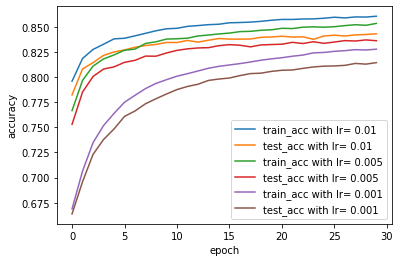

In [ ]:
for i in range(len(accs_train)):
    plt.plot(np.array(accs_train[i]),label= f'train_acc with lr= {lr_list[i]}')
    plt.plot(np.array(accs_test[i]),label= f'test_acc with lr= {lr_list[i]}')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")

In [56]:
final_test_accs=[]
final_train_accs=[]
for i in range(len(accs_test)):
  final_train_accs.append(accs_train[i][len(accs_train[i])-1])
  final_test_accs.append(accs_test[i][len(accs_test[i])-1])
print(final_train_accs)
print(final_valid)
print(final_test_accs)

[0.8592166666666666, 0.8519333333333333, 0.8265]
[0.8535, 0.8525, 0.83]
[0.836125, 0.83375, 0.810875]


# 1-layer

In [57]:
with cp.cuda.Device(0):
    cp.random.seed(913)
    testX_s, testy_s = shuffle(vec_testX, testy)
    trainX_s, trainy_s = shuffle(vec_trainX, trainy)
    accs1_train=[]
    accs1_test=[]
    final_valid= []
    for i in range(len(lr_list)):
        train_acc_tmp=[]
        test_acc_tmp=[]
        mlp1 = MLP(units=[128],num_layers=1)
        opt = GradientDescentOptimizer(mlp1,lr_list[i])
        train_acc_tmp, test_acc_tmp, loss = mlp1.fit(opt,trainX_s,trainy_s,testX_s,testy_s,32,30, evaluate=True)
        y_predicted = cp.argmax(mlp1.predict(validX_s), axis=-1)
        final_valid.append(eval_acc(y_predicted, validy_s))
        accs1_train.append(train_acc_tmp)
        accs1_test.append(test_acc_tmp)

Epoch 0


100%|██████████| 1875/1875 [00:02<00:00, 745.81it/s]


Epoch 1


100%|██████████| 1875/1875 [00:02<00:00, 701.86it/s]


Epoch 2


100%|██████████| 1875/1875 [00:02<00:00, 768.76it/s]


Epoch 3


100%|██████████| 1875/1875 [00:02<00:00, 769.23it/s]


Epoch 4


100%|██████████| 1875/1875 [00:02<00:00, 775.47it/s]


Epoch 5


100%|██████████| 1875/1875 [00:02<00:00, 776.31it/s]


Epoch 6


100%|██████████| 1875/1875 [00:02<00:00, 763.65it/s]


Epoch 7


100%|██████████| 1875/1875 [00:02<00:00, 756.00it/s]


Epoch 8


100%|██████████| 1875/1875 [00:02<00:00, 753.85it/s]


Epoch 9


100%|██████████| 1875/1875 [00:02<00:00, 760.80it/s]


Epoch 10


100%|██████████| 1875/1875 [00:02<00:00, 698.84it/s]


Epoch 11


100%|██████████| 1875/1875 [00:02<00:00, 761.45it/s]


Epoch 12


100%|██████████| 1875/1875 [00:03<00:00, 604.25it/s]


Epoch 13


100%|██████████| 1875/1875 [00:02<00:00, 746.83it/s]


Epoch 14


100%|██████████| 1875/1875 [00:02<00:00, 692.33it/s]


Epoch 15


100%|██████████| 1875/1875 [00:02<00:00, 758.12it/s]


Epoch 16


100%|██████████| 1875/1875 [00:02<00:00, 751.43it/s]


Epoch 17


100%|██████████| 1875/1875 [00:02<00:00, 757.26it/s]


Epoch 18


100%|██████████| 1875/1875 [00:02<00:00, 664.70it/s]


Epoch 19


100%|██████████| 1875/1875 [00:02<00:00, 758.84it/s]


Epoch 20


100%|██████████| 1875/1875 [00:02<00:00, 762.80it/s]


Epoch 21


100%|██████████| 1875/1875 [00:02<00:00, 739.12it/s]


Epoch 22


100%|██████████| 1875/1875 [00:02<00:00, 752.77it/s]


Epoch 23


100%|██████████| 1875/1875 [00:02<00:00, 702.89it/s]


Epoch 24


100%|██████████| 1875/1875 [00:02<00:00, 741.19it/s]


Epoch 25


100%|██████████| 1875/1875 [00:02<00:00, 689.07it/s]


Epoch 26


100%|██████████| 1875/1875 [00:02<00:00, 756.28it/s]


Epoch 27


100%|██████████| 1875/1875 [00:02<00:00, 727.92it/s]


Epoch 28


100%|██████████| 1875/1875 [00:02<00:00, 765.38it/s]


Epoch 29


100%|██████████| 1875/1875 [00:02<00:00, 742.81it/s]


Epoch 0


100%|██████████| 1875/1875 [00:02<00:00, 764.74it/s]


Epoch 1


100%|██████████| 1875/1875 [00:02<00:00, 742.86it/s]


Epoch 2


100%|██████████| 1875/1875 [00:02<00:00, 750.70it/s]


Epoch 3


100%|██████████| 1875/1875 [00:02<00:00, 762.62it/s]


Epoch 4


100%|██████████| 1875/1875 [00:02<00:00, 748.71it/s]


Epoch 5


100%|██████████| 1875/1875 [00:02<00:00, 766.34it/s]


Epoch 6


100%|██████████| 1875/1875 [00:02<00:00, 706.05it/s]


Epoch 7


100%|██████████| 1875/1875 [00:02<00:00, 747.06it/s]


Epoch 8


100%|██████████| 1875/1875 [00:02<00:00, 693.35it/s]


Epoch 9


100%|██████████| 1875/1875 [00:02<00:00, 768.66it/s]


Epoch 10


100%|██████████| 1875/1875 [00:02<00:00, 763.02it/s]


Epoch 11


100%|██████████| 1875/1875 [00:02<00:00, 767.70it/s]


Epoch 12


100%|██████████| 1875/1875 [00:02<00:00, 766.12it/s]


Epoch 13


100%|██████████| 1875/1875 [00:02<00:00, 653.40it/s]


Epoch 14


100%|██████████| 1875/1875 [00:02<00:00, 761.08it/s]


Epoch 15


100%|██████████| 1875/1875 [00:02<00:00, 758.35it/s]


Epoch 16


100%|██████████| 1875/1875 [00:02<00:00, 755.72it/s]


Epoch 17


100%|██████████| 1875/1875 [00:02<00:00, 700.05it/s]


Epoch 18


100%|██████████| 1875/1875 [00:02<00:00, 694.11it/s]


Epoch 19


100%|██████████| 1875/1875 [00:03<00:00, 605.13it/s]


Epoch 20


100%|██████████| 1875/1875 [00:02<00:00, 639.78it/s]


Epoch 21


100%|██████████| 1875/1875 [00:02<00:00, 680.08it/s]


Epoch 22


100%|██████████| 1875/1875 [00:02<00:00, 698.69it/s]


Epoch 23


100%|██████████| 1875/1875 [00:02<00:00, 710.32it/s]


Epoch 24


100%|██████████| 1875/1875 [00:02<00:00, 773.92it/s]


Epoch 25


100%|██████████| 1875/1875 [00:03<00:00, 609.80it/s]


Epoch 26


100%|██████████| 1875/1875 [00:02<00:00, 753.52it/s]


Epoch 27


100%|██████████| 1875/1875 [00:02<00:00, 695.69it/s]


Epoch 28


100%|██████████| 1875/1875 [00:02<00:00, 763.57it/s]


Epoch 29


100%|██████████| 1875/1875 [00:02<00:00, 766.58it/s]


Epoch 0


100%|██████████| 1875/1875 [00:02<00:00, 769.78it/s]


Epoch 1


100%|██████████| 1875/1875 [00:02<00:00, 634.12it/s]


Epoch 2


100%|██████████| 1875/1875 [00:02<00:00, 769.77it/s]


Epoch 3


100%|██████████| 1875/1875 [00:02<00:00, 754.40it/s]


Epoch 4


100%|██████████| 1875/1875 [00:02<00:00, 756.43it/s]


Epoch 5


100%|██████████| 1875/1875 [00:02<00:00, 765.57it/s]


Epoch 6


100%|██████████| 1875/1875 [00:02<00:00, 711.90it/s]


Epoch 7


100%|██████████| 1875/1875 [00:02<00:00, 721.13it/s]


Epoch 8


100%|██████████| 1875/1875 [00:02<00:00, 675.20it/s]


Epoch 9


100%|██████████| 1875/1875 [00:02<00:00, 638.35it/s]


Epoch 10


100%|██████████| 1875/1875 [00:02<00:00, 658.14it/s]


Epoch 11


100%|██████████| 1875/1875 [00:02<00:00, 670.47it/s]


Epoch 12


100%|██████████| 1875/1875 [00:03<00:00, 611.70it/s]


Epoch 13


100%|██████████| 1875/1875 [00:03<00:00, 572.45it/s]


Epoch 14


100%|██████████| 1875/1875 [00:03<00:00, 598.45it/s]


Epoch 15


100%|██████████| 1875/1875 [00:02<00:00, 684.07it/s]


Epoch 16


100%|██████████| 1875/1875 [00:02<00:00, 690.94it/s]


Epoch 17


100%|██████████| 1875/1875 [00:02<00:00, 648.65it/s]


Epoch 18


100%|██████████| 1875/1875 [00:02<00:00, 690.03it/s]


Epoch 19


100%|██████████| 1875/1875 [00:02<00:00, 728.54it/s]


Epoch 20


100%|██████████| 1875/1875 [00:03<00:00, 601.54it/s]


Epoch 21


100%|██████████| 1875/1875 [00:02<00:00, 746.92it/s]


Epoch 22


100%|██████████| 1875/1875 [00:02<00:00, 632.16it/s]


Epoch 23


100%|██████████| 1875/1875 [00:02<00:00, 752.37it/s]


Epoch 24


100%|██████████| 1875/1875 [00:02<00:00, 687.76it/s]


Epoch 25


100%|██████████| 1875/1875 [00:02<00:00, 697.27it/s]


Epoch 26


100%|██████████| 1875/1875 [00:03<00:00, 610.76it/s]


Epoch 27


100%|██████████| 1875/1875 [00:02<00:00, 757.60it/s]


Epoch 28


100%|██████████| 1875/1875 [00:02<00:00, 705.69it/s]


Epoch 29


100%|██████████| 1875/1875 [00:02<00:00, 702.70it/s]


Text(0, 0.5, 'accuracy')

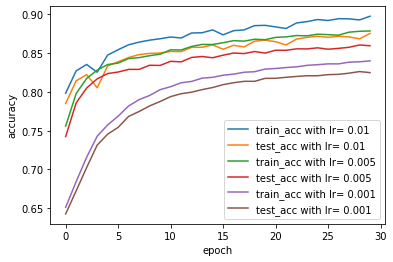

In [ ]:
for i in range(len(accs1_train)):
    plt.plot(np.array(accs1_train[i]),label= f'train_acc with lr= {lr_list[i]}')
    plt.plot(np.array(accs1_test[i]),label= f'test_acc with lr= {lr_list[i]}')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")

In [58]:
final_test_accs1=[]
final_train_accs1=[]
for i in range(len(accs1_test)):
  final_train_accs1.append(accs1_train[i][len(accs1_train[i])-1])
  final_test_accs1.append(accs1_test[i][len(accs1_test[i])-1])
print(final_train_accs1)
print(final_valid)
print(final_test_accs1)

[0.8920666666666667, 0.8755666666666667, 0.8393]
[0.877, 0.8685, 0.839]
[0.863375, 0.855125, 0.8225]


# 2-layer

In [59]:
with cp.cuda.Device(0):
    cp.random.seed(913)
    testX_s, testy_s = shuffle(vec_testX, testy)
    trainX_s, trainy_s = shuffle(vec_trainX, trainy)
    accs2_train=[]
    accs2_test=[]
    final_valid= []
    for i in range(len(lr_list)):
        train_acc_tmp=[]
        test_acc_tmp=[]
        mlp2 = MLP()
        opt = GradientDescentOptimizer(mlp2,lr_list[i])
        train_acc_tmp, test_acc_tmp, loss = mlp2.fit(opt,trainX_s,trainy_s,testX_s,testy_s,32,30, evaluate=True)
        y_predicted = cp.argmax(mlp2.predict(validX_s), axis=-1)
        final_valid.append(eval_acc(y_predicted, validy_s))
        accs2_train.append(train_acc_tmp)
        accs2_test.append(test_acc_tmp)

Epoch 0


100%|██████████| 1875/1875 [00:03<00:00, 514.01it/s]


Epoch 1


100%|██████████| 1875/1875 [00:03<00:00, 565.44it/s]


Epoch 2


100%|██████████| 1875/1875 [00:03<00:00, 569.45it/s]


Epoch 3


100%|██████████| 1875/1875 [00:03<00:00, 571.94it/s]


Epoch 4


100%|██████████| 1875/1875 [00:03<00:00, 550.96it/s]


Epoch 5


100%|██████████| 1875/1875 [00:03<00:00, 574.55it/s]


Epoch 6


100%|██████████| 1875/1875 [00:03<00:00, 531.85it/s]


Epoch 7


100%|██████████| 1875/1875 [00:03<00:00, 561.46it/s]


Epoch 8


100%|██████████| 1875/1875 [00:03<00:00, 534.74it/s]


Epoch 9


100%|██████████| 1875/1875 [00:03<00:00, 567.26it/s]


Epoch 10


100%|██████████| 1875/1875 [00:03<00:00, 525.83it/s]


Epoch 11


100%|██████████| 1875/1875 [00:03<00:00, 504.96it/s]


Epoch 12


100%|██████████| 1875/1875 [00:03<00:00, 531.64it/s]


Epoch 13


100%|██████████| 1875/1875 [00:03<00:00, 571.20it/s]


Epoch 14


100%|██████████| 1875/1875 [00:03<00:00, 544.28it/s]


Epoch 15


100%|██████████| 1875/1875 [00:03<00:00, 572.87it/s]


Epoch 16


100%|██████████| 1875/1875 [00:03<00:00, 507.04it/s]


Epoch 17


100%|██████████| 1875/1875 [00:03<00:00, 493.73it/s]


Epoch 18


100%|██████████| 1875/1875 [00:03<00:00, 514.20it/s]


Epoch 19


100%|██████████| 1875/1875 [00:04<00:00, 446.65it/s]


Epoch 20


100%|██████████| 1875/1875 [00:03<00:00, 517.85it/s]


Epoch 21


100%|██████████| 1875/1875 [00:03<00:00, 471.71it/s]


Epoch 22


100%|██████████| 1875/1875 [00:03<00:00, 571.47it/s]


Epoch 23


100%|██████████| 1875/1875 [00:03<00:00, 571.04it/s]


Epoch 24


100%|██████████| 1875/1875 [00:03<00:00, 569.23it/s]


Epoch 25


100%|██████████| 1875/1875 [00:03<00:00, 566.30it/s]


Epoch 26


100%|██████████| 1875/1875 [00:03<00:00, 573.02it/s]


Epoch 27


100%|██████████| 1875/1875 [00:03<00:00, 571.69it/s]


Epoch 28


100%|██████████| 1875/1875 [00:03<00:00, 538.47it/s]


Epoch 29


100%|██████████| 1875/1875 [00:03<00:00, 573.31it/s]


Epoch 0


100%|██████████| 1875/1875 [00:03<00:00, 531.35it/s]


Epoch 1


100%|██████████| 1875/1875 [00:03<00:00, 567.23it/s]


Epoch 2


100%|██████████| 1875/1875 [00:03<00:00, 490.05it/s]


Epoch 3


100%|██████████| 1875/1875 [00:03<00:00, 563.82it/s]


Epoch 4


100%|██████████| 1875/1875 [00:03<00:00, 552.36it/s]


Epoch 5


100%|██████████| 1875/1875 [00:03<00:00, 568.76it/s]


Epoch 6


100%|██████████| 1875/1875 [00:03<00:00, 572.36it/s]


Epoch 7


100%|██████████| 1875/1875 [00:03<00:00, 509.88it/s]


Epoch 8


100%|██████████| 1875/1875 [00:03<00:00, 571.61it/s]


Epoch 9


100%|██████████| 1875/1875 [00:03<00:00, 539.79it/s]


Epoch 10


100%|██████████| 1875/1875 [00:03<00:00, 562.57it/s]


Epoch 11


100%|██████████| 1875/1875 [00:03<00:00, 525.20it/s]


Epoch 12


100%|██████████| 1875/1875 [00:03<00:00, 529.29it/s]


Epoch 13


100%|██████████| 1875/1875 [00:03<00:00, 533.05it/s]


Epoch 14


100%|██████████| 1875/1875 [00:03<00:00, 562.35it/s]


Epoch 15


100%|██████████| 1875/1875 [00:03<00:00, 535.32it/s]


Epoch 16


100%|██████████| 1875/1875 [00:03<00:00, 565.98it/s]


Epoch 17


100%|██████████| 1875/1875 [00:03<00:00, 549.70it/s]


Epoch 18


100%|██████████| 1875/1875 [00:03<00:00, 566.57it/s]


Epoch 19


100%|██████████| 1875/1875 [00:03<00:00, 568.36it/s]


Epoch 20


100%|██████████| 1875/1875 [00:03<00:00, 570.39it/s]


Epoch 21


100%|██████████| 1875/1875 [00:03<00:00, 555.43it/s]


Epoch 22


100%|██████████| 1875/1875 [00:03<00:00, 532.79it/s]


Epoch 23


100%|██████████| 1875/1875 [00:03<00:00, 497.22it/s]


Epoch 24


100%|██████████| 1875/1875 [00:03<00:00, 524.95it/s]


Epoch 25


100%|██████████| 1875/1875 [00:03<00:00, 565.90it/s]


Epoch 26


100%|██████████| 1875/1875 [00:03<00:00, 516.17it/s]


Epoch 27


100%|██████████| 1875/1875 [00:03<00:00, 566.89it/s]


Epoch 28


100%|██████████| 1875/1875 [00:03<00:00, 499.16it/s]


Epoch 29


100%|██████████| 1875/1875 [00:03<00:00, 562.58it/s]


Epoch 0


100%|██████████| 1875/1875 [00:03<00:00, 565.03it/s]


Epoch 1


100%|██████████| 1875/1875 [00:03<00:00, 552.26it/s]


Epoch 2


100%|██████████| 1875/1875 [00:03<00:00, 567.51it/s]


Epoch 3


100%|██████████| 1875/1875 [00:03<00:00, 529.91it/s]


Epoch 4


100%|██████████| 1875/1875 [00:03<00:00, 561.47it/s]


Epoch 5


100%|██████████| 1875/1875 [00:03<00:00, 536.30it/s]


Epoch 6


100%|██████████| 1875/1875 [00:03<00:00, 561.24it/s]


Epoch 7


100%|██████████| 1875/1875 [00:03<00:00, 534.10it/s]


Epoch 8


100%|██████████| 1875/1875 [00:03<00:00, 567.55it/s]


Epoch 9


100%|██████████| 1875/1875 [00:03<00:00, 523.98it/s]


Epoch 10


100%|██████████| 1875/1875 [00:03<00:00, 572.10it/s]


Epoch 11


100%|██████████| 1875/1875 [00:03<00:00, 560.57it/s]


Epoch 12


100%|██████████| 1875/1875 [00:03<00:00, 557.52it/s]


Epoch 13


100%|██████████| 1875/1875 [00:03<00:00, 565.28it/s]


Epoch 14


100%|██████████| 1875/1875 [00:03<00:00, 494.76it/s]


Epoch 15


100%|██████████| 1875/1875 [00:03<00:00, 572.52it/s]


Epoch 16


100%|██████████| 1875/1875 [00:03<00:00, 508.84it/s]


Epoch 17


100%|██████████| 1875/1875 [00:03<00:00, 548.30it/s]


Epoch 18


100%|██████████| 1875/1875 [00:03<00:00, 536.09it/s]


Epoch 19


100%|██████████| 1875/1875 [00:03<00:00, 516.93it/s]


Epoch 20


100%|██████████| 1875/1875 [00:03<00:00, 538.35it/s]


Epoch 21


100%|██████████| 1875/1875 [00:03<00:00, 563.04it/s]


Epoch 22


100%|██████████| 1875/1875 [00:03<00:00, 536.31it/s]


Epoch 23


100%|██████████| 1875/1875 [00:03<00:00, 569.15it/s]


Epoch 24


100%|██████████| 1875/1875 [00:03<00:00, 561.29it/s]


Epoch 25


100%|██████████| 1875/1875 [00:03<00:00, 558.61it/s]


Epoch 26


100%|██████████| 1875/1875 [00:03<00:00, 571.06it/s]


Epoch 27


100%|██████████| 1875/1875 [00:03<00:00, 563.83it/s]


Epoch 28


100%|██████████| 1875/1875 [00:03<00:00, 566.20it/s]


Epoch 29


100%|██████████| 1875/1875 [00:03<00:00, 538.80it/s]


Text(0, 0.5, 'accuracy')

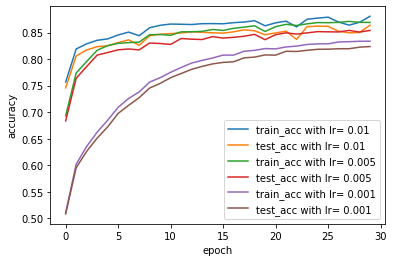

In [ ]:
for i in range(len(accs2_train)):
    plt.plot(np.array(accs2_train[i]),label= f'train_acc with lr= {lr_list[i]}')
    plt.plot(np.array(accs2_test[i]),label= f'test_acc with lr= {lr_list[i]}')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")

In [61]:
final_test_accs2=[]
final_train_accs2=[]
for i in range(len(accs2_test)):
  final_train_accs2.append(accs2_train[i][len(accs2_train[i])-1])
  final_test_accs2.append(accs2_test[i][len(accs2_test[i])-1])
print(final_train_accs2)
print(final_valid)
print(final_test_accs2)

[0.8833166666666666, 0.87105, 0.83465]
[0.871, 0.8675, 0.8415]
[0.86125, 0.853125, 0.817125]


# 2-layer with Regularization

In [62]:
reg_coef=[0.01,0.001,0.0001]

In [63]:
with cp.cuda.Device(0):
    cp.random.seed(913)
    testX_s, testy_s = shuffle(vec_testX, testy)
    trainX_s, trainy_s = shuffle(vec_trainX, trainy)
    accs2_train_r=[]
    accs2_test_r=[]
    final_valid= []
    for i in range(len(reg_coef)):
        train_acc_tmp=[]
        test_acc_tmp=[]
        mlp2_r = MLP(regularization=reg_coef[i])
        opt = GradientDescentOptimizer(mlp2_r,0.01)
        train_acc_tmp, test_acc_tmp, loss = mlp2_r.fit(opt,trainX_s,trainy_s,testX_s,testy_s,32,30, evaluate=True)
        y_predicted = cp.argmax(mlp2_r.predict(validX_s), axis=-1)
        final_valid.append(eval_acc(y_predicted, validy_s))
        accs2_train_r.append(train_acc_tmp)
        accs2_test_r.append(test_acc_tmp)

Epoch 0


100%|██████████| 1875/1875 [00:03<00:00, 516.12it/s]


Epoch 1


100%|██████████| 1875/1875 [00:03<00:00, 535.13it/s]


Epoch 2


100%|██████████| 1875/1875 [00:03<00:00, 570.04it/s]


Epoch 3


100%|██████████| 1875/1875 [00:03<00:00, 539.74it/s]


Epoch 4


100%|██████████| 1875/1875 [00:03<00:00, 562.20it/s]


Epoch 5


100%|██████████| 1875/1875 [00:03<00:00, 485.93it/s]


Epoch 6


100%|██████████| 1875/1875 [00:03<00:00, 575.07it/s]


Epoch 7


100%|██████████| 1875/1875 [00:03<00:00, 539.09it/s]


Epoch 8


100%|██████████| 1875/1875 [00:03<00:00, 576.74it/s]


Epoch 9


100%|██████████| 1875/1875 [00:03<00:00, 578.03it/s]


Epoch 10


100%|██████████| 1875/1875 [00:03<00:00, 570.39it/s]


Epoch 11


100%|██████████| 1875/1875 [00:03<00:00, 567.83it/s]


Epoch 12


100%|██████████| 1875/1875 [00:03<00:00, 534.35it/s]


Epoch 13


100%|██████████| 1875/1875 [00:03<00:00, 573.13it/s]


Epoch 14


100%|██████████| 1875/1875 [00:03<00:00, 537.27it/s]


Epoch 15


100%|██████████| 1875/1875 [00:03<00:00, 569.10it/s]


Epoch 16


100%|██████████| 1875/1875 [00:03<00:00, 484.61it/s]


Epoch 17


100%|██████████| 1875/1875 [00:03<00:00, 563.60it/s]


Epoch 18


100%|██████████| 1875/1875 [00:03<00:00, 539.73it/s]


Epoch 19


100%|██████████| 1875/1875 [00:03<00:00, 576.68it/s]


Epoch 20


100%|██████████| 1875/1875 [00:03<00:00, 538.46it/s]


Epoch 21


100%|██████████| 1875/1875 [00:03<00:00, 512.32it/s]


Epoch 22


100%|██████████| 1875/1875 [00:03<00:00, 562.80it/s]


Epoch 23


100%|██████████| 1875/1875 [00:03<00:00, 569.84it/s]


Epoch 24


100%|██████████| 1875/1875 [00:03<00:00, 570.81it/s]


Epoch 25


100%|██████████| 1875/1875 [00:03<00:00, 569.44it/s]


Epoch 26


100%|██████████| 1875/1875 [00:03<00:00, 575.74it/s]


Epoch 27


100%|██████████| 1875/1875 [00:03<00:00, 540.29it/s]


Epoch 28


100%|██████████| 1875/1875 [00:03<00:00, 576.35it/s]


Epoch 29


100%|██████████| 1875/1875 [00:03<00:00, 543.22it/s]


Epoch 0


100%|██████████| 1875/1875 [00:03<00:00, 576.27it/s]


Epoch 1


100%|██████████| 1875/1875 [00:03<00:00, 535.68it/s]


Epoch 2


100%|██████████| 1875/1875 [00:03<00:00, 512.22it/s]


Epoch 3


100%|██████████| 1875/1875 [00:03<00:00, 528.49it/s]


Epoch 4


100%|██████████| 1875/1875 [00:03<00:00, 575.34it/s]


Epoch 5


100%|██████████| 1875/1875 [00:03<00:00, 569.48it/s]


Epoch 6


100%|██████████| 1875/1875 [00:03<00:00, 569.33it/s]


Epoch 7


100%|██████████| 1875/1875 [00:03<00:00, 513.81it/s]


Epoch 8


100%|██████████| 1875/1875 [00:03<00:00, 563.54it/s]


Epoch 9


100%|██████████| 1875/1875 [00:03<00:00, 568.96it/s]


Epoch 10


100%|██████████| 1875/1875 [00:03<00:00, 537.40it/s]


Epoch 11


100%|██████████| 1875/1875 [00:03<00:00, 577.39it/s]


Epoch 12


100%|██████████| 1875/1875 [00:03<00:00, 536.29it/s]


Epoch 13


100%|██████████| 1875/1875 [00:03<00:00, 573.78it/s]


Epoch 14


100%|██████████| 1875/1875 [00:03<00:00, 539.27it/s]


Epoch 15


100%|██████████| 1875/1875 [00:03<00:00, 565.16it/s]


Epoch 16


100%|██████████| 1875/1875 [00:03<00:00, 541.94it/s]


Epoch 17


100%|██████████| 1875/1875 [00:03<00:00, 577.30it/s]


Epoch 18


100%|██████████| 1875/1875 [00:04<00:00, 459.35it/s]


Epoch 19


100%|██████████| 1875/1875 [00:03<00:00, 578.93it/s]


Epoch 20


100%|██████████| 1875/1875 [00:03<00:00, 574.44it/s]


Epoch 21


100%|██████████| 1875/1875 [00:03<00:00, 574.11it/s]


Epoch 22


100%|██████████| 1875/1875 [00:03<00:00, 563.60it/s]


Epoch 23


100%|██████████| 1875/1875 [00:03<00:00, 493.48it/s]


Epoch 24


100%|██████████| 1875/1875 [00:03<00:00, 573.98it/s]


Epoch 25


100%|██████████| 1875/1875 [00:03<00:00, 530.77it/s]


Epoch 26


100%|██████████| 1875/1875 [00:03<00:00, 574.84it/s]


Epoch 27


100%|██████████| 1875/1875 [00:03<00:00, 537.33it/s]


Epoch 28


100%|██████████| 1875/1875 [00:03<00:00, 575.31it/s]


Epoch 29


100%|██████████| 1875/1875 [00:03<00:00, 536.31it/s]


Epoch 0


100%|██████████| 1875/1875 [00:03<00:00, 574.40it/s]


Epoch 1


100%|██████████| 1875/1875 [00:03<00:00, 538.18it/s]


Epoch 2


100%|██████████| 1875/1875 [00:03<00:00, 574.87it/s]


Epoch 3


100%|██████████| 1875/1875 [00:03<00:00, 565.53it/s]


Epoch 4


100%|██████████| 1875/1875 [00:03<00:00, 504.08it/s]


Epoch 5


100%|██████████| 1875/1875 [00:03<00:00, 572.06it/s]


Epoch 6


100%|██████████| 1875/1875 [00:03<00:00, 565.17it/s]


Epoch 7


100%|██████████| 1875/1875 [00:03<00:00, 567.39it/s]


Epoch 8


100%|██████████| 1875/1875 [00:03<00:00, 551.49it/s]


Epoch 9


100%|██████████| 1875/1875 [00:03<00:00, 511.92it/s]


Epoch 10


100%|██████████| 1875/1875 [00:03<00:00, 540.14it/s]


Epoch 11


100%|██████████| 1875/1875 [00:03<00:00, 573.04it/s]


Epoch 12


100%|██████████| 1875/1875 [00:03<00:00, 533.03it/s]


Epoch 13


100%|██████████| 1875/1875 [00:03<00:00, 574.95it/s]


Epoch 14


100%|██████████| 1875/1875 [00:03<00:00, 537.69it/s]


Epoch 15


100%|██████████| 1875/1875 [00:03<00:00, 577.01it/s]


Epoch 16


100%|██████████| 1875/1875 [00:03<00:00, 557.28it/s]


Epoch 17


100%|██████████| 1875/1875 [00:03<00:00, 571.20it/s]


Epoch 18


100%|██████████| 1875/1875 [00:03<00:00, 574.91it/s]


Epoch 19


100%|██████████| 1875/1875 [00:03<00:00, 571.64it/s]


Epoch 20


100%|██████████| 1875/1875 [00:03<00:00, 508.14it/s]


Epoch 21


100%|██████████| 1875/1875 [00:03<00:00, 576.00it/s]


Epoch 22


100%|██████████| 1875/1875 [00:03<00:00, 577.83it/s]


Epoch 23


100%|██████████| 1875/1875 [00:03<00:00, 536.20it/s]


Epoch 24


100%|██████████| 1875/1875 [00:03<00:00, 574.97it/s]


Epoch 25


100%|██████████| 1875/1875 [00:03<00:00, 481.09it/s]


Epoch 26


100%|██████████| 1875/1875 [00:03<00:00, 573.21it/s]


Epoch 27


100%|██████████| 1875/1875 [00:03<00:00, 542.48it/s]


Epoch 28


100%|██████████| 1875/1875 [00:03<00:00, 577.28it/s]


Epoch 29


100%|██████████| 1875/1875 [00:03<00:00, 517.32it/s]


Text(0, 0.5, 'accuracy')

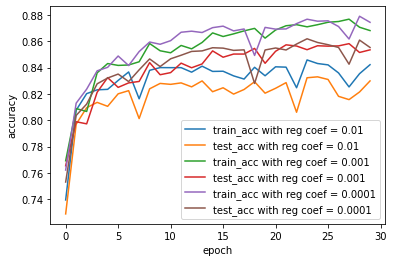

In [ ]:
for i in range(len(accs2_train_r)):
    plt.plot(np.array(accs2_train_r[i]),label= f'train_acc with reg coef = {reg_coef[i]}')
    plt.plot(np.array(accs2_test_r[i]),label= f'test_acc with reg coef = {reg_coef[i]}')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")

In [64]:
final_test_accs2_r=[]
final_train_accs2_r=[]
for i in range(len(accs2_test_r)):
  final_train_accs2_r.append(accs2_train_r[i][len(accs2_train_r[i])-1])
  final_test_accs2_r.append(accs2_test_r[i][len(accs2_test_r[i])-1])
print(final_train_accs2_r)
print(final_valid)
print(final_test_accs2_r)

[0.8484333333333334, 0.8726666666666667, 0.8821833333333333]
[0.851, 0.8645, 0.8715]
[0.82825, 0.84975, 0.860375]


# LeakyRelu

In [71]:
with cp.cuda.Device(0):
    cp.random.seed(913)
    testX_s, testy_s = shuffle(vec_testX, testy)
    trainX_s, trainy_s = shuffle(vec_trainX, trainy)
    accs2_train_lrelu=[]
    accs2_test_lrelu=[]
    final_valid= []
    for i in range(len(leaky_lr_list)):
        train_acc_tmp=[]
        test_acc_tmp=[]
        mlp2_lrelu = MLP(activation_fn=LeakyReLULayer(0.1))
        opt = GradientDescentOptimizer(mlp2_lrelu,leaky_lr_list[i])
        train_acc_tmp, test_acc_tmp, loss = mlp2_lrelu.fit(opt,trainX_s,trainy_s,testX_s,testy_s,32,30, evaluate=True)
        y_predicted = cp.argmax(mlp2_lrelu.predict(validX_s), axis=-1)
        final_valid.append(eval_acc(y_predicted, validy_s))
        accs2_train_lrelu.append(train_acc_tmp)
        accs2_test_lrelu.append(test_acc_tmp)

Epoch 0


100%|██████████| 1875/1875 [00:03<00:00, 476.85it/s]


Epoch 1


100%|██████████| 1875/1875 [00:03<00:00, 481.43it/s]


Epoch 2


100%|██████████| 1875/1875 [00:04<00:00, 453.86it/s]


Epoch 3


100%|██████████| 1875/1875 [00:04<00:00, 442.87it/s]


Epoch 4


100%|██████████| 1875/1875 [00:04<00:00, 458.09it/s]


Epoch 5


100%|██████████| 1875/1875 [00:03<00:00, 473.93it/s]


Epoch 6


100%|██████████| 1875/1875 [00:03<00:00, 481.24it/s]


Epoch 7


100%|██████████| 1875/1875 [00:04<00:00, 454.48it/s]


Epoch 8


100%|██████████| 1875/1875 [00:04<00:00, 443.35it/s]


Epoch 9


100%|██████████| 1875/1875 [00:04<00:00, 459.43it/s]


Epoch 10


100%|██████████| 1875/1875 [00:03<00:00, 480.60it/s]


Epoch 11


100%|██████████| 1875/1875 [00:03<00:00, 481.87it/s]


Epoch 12


100%|██████████| 1875/1875 [00:03<00:00, 478.93it/s]


Epoch 13


100%|██████████| 1875/1875 [00:04<00:00, 446.51it/s]


Epoch 14


100%|██████████| 1875/1875 [00:04<00:00, 458.40it/s]


Epoch 15


100%|██████████| 1875/1875 [00:03<00:00, 487.14it/s]


Epoch 16


100%|██████████| 1875/1875 [00:03<00:00, 469.55it/s]


Epoch 17


100%|██████████| 1875/1875 [00:03<00:00, 477.19it/s]


Epoch 18


100%|██████████| 1875/1875 [00:03<00:00, 486.15it/s]


Epoch 19


100%|██████████| 1875/1875 [00:04<00:00, 458.37it/s]


Epoch 20


100%|██████████| 1875/1875 [00:03<00:00, 479.79it/s]


Epoch 21


100%|██████████| 1875/1875 [00:04<00:00, 462.08it/s]


Epoch 22


100%|██████████| 1875/1875 [00:03<00:00, 486.88it/s]


Epoch 23


100%|██████████| 1875/1875 [00:03<00:00, 488.69it/s]


Epoch 24


100%|██████████| 1875/1875 [00:04<00:00, 463.68it/s]


Epoch 25


100%|██████████| 1875/1875 [00:03<00:00, 481.78it/s]


Epoch 26


100%|██████████| 1875/1875 [00:04<00:00, 452.69it/s]


Epoch 27


100%|██████████| 1875/1875 [00:04<00:00, 445.40it/s]


Epoch 28


100%|██████████| 1875/1875 [00:03<00:00, 476.88it/s]


Epoch 29


100%|██████████| 1875/1875 [00:04<00:00, 454.47it/s]


Epoch 0


100%|██████████| 1875/1875 [00:03<00:00, 480.05it/s]


Epoch 1


100%|██████████| 1875/1875 [00:04<00:00, 461.81it/s]


Epoch 2


100%|██████████| 1875/1875 [00:04<00:00, 441.83it/s]


Epoch 3


100%|██████████| 1875/1875 [00:03<00:00, 485.53it/s]


Epoch 4


100%|██████████| 1875/1875 [00:04<00:00, 456.40it/s]


Epoch 5


100%|██████████| 1875/1875 [00:04<00:00, 457.96it/s]


Epoch 6


100%|██████████| 1875/1875 [00:04<00:00, 460.43it/s]


Epoch 7


100%|██████████| 1875/1875 [00:04<00:00, 437.91it/s]


Epoch 8


100%|██████████| 1875/1875 [00:03<00:00, 484.72it/s]


Epoch 9


100%|██████████| 1875/1875 [00:04<00:00, 416.99it/s]


Epoch 10


100%|██████████| 1875/1875 [00:03<00:00, 473.94it/s]


Epoch 11


100%|██████████| 1875/1875 [00:04<00:00, 437.46it/s]


Epoch 12


100%|██████████| 1875/1875 [00:04<00:00, 459.76it/s]


Epoch 13


100%|██████████| 1875/1875 [00:03<00:00, 481.01it/s]


Epoch 14


100%|██████████| 1875/1875 [00:04<00:00, 452.60it/s]


Epoch 15


100%|██████████| 1875/1875 [00:03<00:00, 484.70it/s]


Epoch 16


100%|██████████| 1875/1875 [00:04<00:00, 425.74it/s]


Epoch 17


100%|██████████| 1875/1875 [00:03<00:00, 484.96it/s]


Epoch 18


100%|██████████| 1875/1875 [00:03<00:00, 481.12it/s]


Epoch 19


100%|██████████| 1875/1875 [00:04<00:00, 443.95it/s]


Epoch 20


100%|██████████| 1875/1875 [00:03<00:00, 486.03it/s]


Epoch 21


100%|██████████| 1875/1875 [00:04<00:00, 417.27it/s]


Epoch 22


100%|██████████| 1875/1875 [00:03<00:00, 483.70it/s]


Epoch 23


100%|██████████| 1875/1875 [00:03<00:00, 477.50it/s]


Epoch 24


100%|██████████| 1875/1875 [00:04<00:00, 456.41it/s]


Epoch 25


100%|██████████| 1875/1875 [00:03<00:00, 480.50it/s]


Epoch 26


100%|██████████| 1875/1875 [00:04<00:00, 413.43it/s]


Epoch 27


100%|██████████| 1875/1875 [00:03<00:00, 477.31it/s]


Epoch 28


100%|██████████| 1875/1875 [00:03<00:00, 479.10it/s]


Epoch 29


100%|██████████| 1875/1875 [00:03<00:00, 480.49it/s]


Epoch 0


100%|██████████| 1875/1875 [00:03<00:00, 486.77it/s]


Epoch 1


100%|██████████| 1875/1875 [00:04<00:00, 420.21it/s]


Epoch 2


100%|██████████| 1875/1875 [00:03<00:00, 482.11it/s]


Epoch 3


100%|██████████| 1875/1875 [00:03<00:00, 469.34it/s]


Epoch 4


100%|██████████| 1875/1875 [00:03<00:00, 484.06it/s]


Epoch 5


100%|██████████| 1875/1875 [00:03<00:00, 481.46it/s]


Epoch 6


100%|██████████| 1875/1875 [00:04<00:00, 451.98it/s]


Epoch 7


100%|██████████| 1875/1875 [00:03<00:00, 480.46it/s]


Epoch 8


100%|██████████| 1875/1875 [00:04<00:00, 459.39it/s]


Epoch 9


100%|██████████| 1875/1875 [00:03<00:00, 483.42it/s]


Epoch 10


100%|██████████| 1875/1875 [00:04<00:00, 466.60it/s]


Epoch 11


100%|██████████| 1875/1875 [00:04<00:00, 455.84it/s]


Epoch 12


100%|██████████| 1875/1875 [00:03<00:00, 484.06it/s]


Epoch 13


100%|██████████| 1875/1875 [00:04<00:00, 457.10it/s]


Epoch 14


100%|██████████| 1875/1875 [00:03<00:00, 480.89it/s]


Epoch 15


100%|██████████| 1875/1875 [00:04<00:00, 439.28it/s]


Epoch 16


100%|██████████| 1875/1875 [00:04<00:00, 454.55it/s]


Epoch 17


100%|██████████| 1875/1875 [00:03<00:00, 487.13it/s]


Epoch 18


100%|██████████| 1875/1875 [00:04<00:00, 453.87it/s]


Epoch 19


100%|██████████| 1875/1875 [00:03<00:00, 479.17it/s]


Epoch 20


100%|██████████| 1875/1875 [00:04<00:00, 439.29it/s]


Epoch 21


100%|██████████| 1875/1875 [00:04<00:00, 449.28it/s]


Epoch 22


100%|██████████| 1875/1875 [00:03<00:00, 487.00it/s]


Epoch 23


100%|██████████| 1875/1875 [00:04<00:00, 446.32it/s]


Epoch 24


100%|██████████| 1875/1875 [00:03<00:00, 484.56it/s]


Epoch 25


100%|██████████| 1875/1875 [00:04<00:00, 439.54it/s]


Epoch 26


100%|██████████| 1875/1875 [00:04<00:00, 463.18it/s]


Epoch 27


100%|██████████| 1875/1875 [00:03<00:00, 488.54it/s]


Epoch 28


100%|██████████| 1875/1875 [00:04<00:00, 450.88it/s]


Epoch 29


100%|██████████| 1875/1875 [00:03<00:00, 477.52it/s]


Text(0, 0.5, 'accuracy')

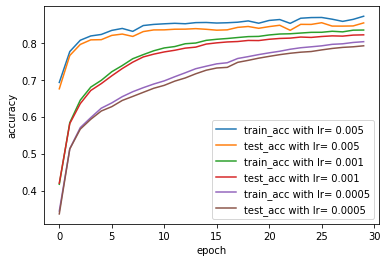

In [ ]:
for i in range(len(accs2_train_lrelu)):
    plt.plot(np.array(accs2_train_lrelu[i]),label= f'train_acc with lr= {leaky_lr_list[i]}')
    plt.plot(np.array(accs2_test_lrelu[i]),label= f'test_acc with lr= {leaky_lr_list[i]}')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")

In [72]:
final_test_accs2_lrelu=[]
final_train_accs2_lrelu=[]
for i in range(len(accs2_test_lrelu)):
  final_train_accs2_lrelu.append(accs2_train_lrelu[i][len(accs2_train_lrelu[i])-1])
  final_test_accs2_lrelu.append(accs2_test_lrelu[i][len(accs2_test_lrelu[i])-1])
print(final_train_accs2_lrelu)
print(final_valid)
print(final_test_accs2_lrelu)

[0.8727, 0.8367833333333333, 0.8015166666666667]
[0.866, 0.841, 0.8065]
[0.851125, 0.819875, 0.786625]


# Tanh

In [67]:
with cp.cuda.Device(0):
    cp.random.seed(913)
    testX_s, testy_s = shuffle(vec_testX, testy)
    trainX_s, trainy_s = shuffle(vec_trainX, trainy)
    accs2_train_tanh=[]
    accs2_test_tanh=[]
    final_valid= []
    for i in range(len(tanh_lr_list)):
        train_acc_tmp=[]
        test_acc_tmp=[]
        mlp2_tanh = MLP(activation_fn=TanhLayer())
        opt = GradientDescentOptimizer(mlp2_tanh,tanh_lr_list[i])
        train_acc_tmp, test_acc_tmp, loss = mlp2_tanh.fit(opt,trainX_s,trainy_s,testX_s,testy_s,32,30, evaluate=True)
        y_predicted = cp.argmax(mlp2_tanh.predict(validX_s), axis=-1)
        final_valid.append(eval_acc(y_predicted, validy_s))
        accs2_train_tanh.append(train_acc_tmp)
        accs2_test_tanh.append(test_acc_tmp)

Epoch 23


100%|██████████| 1875/1875 [00:03<00:00, 577.79it/s]


Epoch 24


100%|██████████| 1875/1875 [00:03<00:00, 587.95it/s]


Epoch 25


100%|██████████| 1875/1875 [00:03<00:00, 555.19it/s]


Epoch 26


100%|██████████| 1875/1875 [00:03<00:00, 568.91it/s]


Epoch 27


100%|██████████| 1875/1875 [00:03<00:00, 547.04it/s]


Epoch 28


100%|██████████| 1875/1875 [00:03<00:00, 584.38it/s]


Epoch 29


100%|██████████| 1875/1875 [00:03<00:00, 552.79it/s]


Epoch 0


100%|██████████| 1875/1875 [00:03<00:00, 532.62it/s]


Epoch 1


100%|██████████| 1875/1875 [00:03<00:00, 547.82it/s]


Epoch 2


100%|██████████| 1875/1875 [00:03<00:00, 592.25it/s]


Epoch 3


100%|██████████| 1875/1875 [00:03<00:00, 554.28it/s]


Epoch 4


100%|██████████| 1875/1875 [00:03<00:00, 596.88it/s]


Epoch 5


100%|██████████| 1875/1875 [00:03<00:00, 571.02it/s]


Epoch 6


100%|██████████| 1875/1875 [00:03<00:00, 595.75it/s]


Epoch 7


100%|██████████| 1875/1875 [00:03<00:00, 582.94it/s]


Epoch 8


100%|██████████| 1875/1875 [00:03<00:00, 589.68it/s]


Epoch 9


100%|██████████| 1875/1875 [00:03<00:00, 592.59it/s]


Epoch 10


100%|██████████| 1875/1875 [00:03<00:00, 580.19it/s]


Epoch 11


100%|██████████| 1875/1875 [00:03<00:00, 532.25it/s]


Epoch 12


100%|██████████| 1875/1875 [00:03<00:00, 573.52it/s]


Epoch 13


100%|██████████| 1875/1875 [00:03<00:00, 588.09it/s]


Epoch 14


100%|██████████| 1875/1875 [00:03<00:00, 554.54it/s]


Epoch 15


100%|██████████| 1875/1875 [00:03<00:00, 590.52it/s]


Epoch 16


100%|██████████| 1875/1875 [00:03<00:00, 507.64it/s]


Epoch 17


100%|██████████| 1875/1875 [00:03<00:00, 593.13it/s]


Epoch 18


100%|██████████| 1875/1875 [00:03<00:00, 551.13it/s]


Epoch 19


100%|██████████| 1875/1875 [00:03<00:00, 594.92it/s]


Epoch 20


100%|██████████| 1875/1875 [00:03<00:00, 550.96it/s]


Epoch 21


100%|██████████| 1875/1875 [00:03<00:00, 591.34it/s]


Epoch 22


100%|██████████| 1875/1875 [00:03<00:00, 516.90it/s]


Epoch 23


100%|██████████| 1875/1875 [00:03<00:00, 594.17it/s]


Epoch 24


100%|██████████| 1875/1875 [00:03<00:00, 550.04it/s]


Epoch 25


100%|██████████| 1875/1875 [00:03<00:00, 594.61it/s]


Epoch 26


100%|██████████| 1875/1875 [00:03<00:00, 570.52it/s]


Epoch 27


100%|██████████| 1875/1875 [00:03<00:00, 523.99it/s]


Epoch 28


100%|██████████| 1875/1875 [00:03<00:00, 586.27it/s]


Epoch 29


100%|██████████| 1875/1875 [00:03<00:00, 591.96it/s]


Epoch 0


100%|██████████| 1875/1875 [00:03<00:00, 594.66it/s]


Epoch 1


100%|██████████| 1875/1875 [00:03<00:00, 590.47it/s]


Epoch 2


100%|██████████| 1875/1875 [00:03<00:00, 596.97it/s]


Epoch 3


100%|██████████| 1875/1875 [00:03<00:00, 583.13it/s]


Epoch 4


100%|██████████| 1875/1875 [00:03<00:00, 592.99it/s]


Epoch 5


100%|██████████| 1875/1875 [00:03<00:00, 565.44it/s]


Epoch 6


100%|██████████| 1875/1875 [00:03<00:00, 592.42it/s]


Epoch 7


100%|██████████| 1875/1875 [00:03<00:00, 554.16it/s]


Epoch 8


100%|██████████| 1875/1875 [00:03<00:00, 527.61it/s]


Epoch 9


100%|██████████| 1875/1875 [00:03<00:00, 554.54it/s]


Epoch 10


100%|██████████| 1875/1875 [00:03<00:00, 587.86it/s]


Epoch 11


100%|██████████| 1875/1875 [00:03<00:00, 541.77it/s]


Epoch 12


100%|██████████| 1875/1875 [00:03<00:00, 592.74it/s]


Epoch 13


100%|██████████| 1875/1875 [00:03<00:00, 553.90it/s]


Epoch 14


100%|██████████| 1875/1875 [00:03<00:00, 586.62it/s]


Epoch 15


100%|██████████| 1875/1875 [00:03<00:00, 558.07it/s]


Epoch 16


100%|██████████| 1875/1875 [00:03<00:00, 591.70it/s]


Epoch 17


100%|██████████| 1875/1875 [00:03<00:00, 554.38it/s]


Epoch 18


100%|██████████| 1875/1875 [00:03<00:00, 584.35it/s]


Epoch 19


100%|██████████| 1875/1875 [00:03<00:00, 511.36it/s]


Epoch 20


100%|██████████| 1875/1875 [00:03<00:00, 588.94it/s]


Epoch 21


100%|██████████| 1875/1875 [00:03<00:00, 594.20it/s]


Epoch 22


100%|██████████| 1875/1875 [00:03<00:00, 581.05it/s]


Epoch 23


100%|██████████| 1875/1875 [00:03<00:00, 595.27it/s]


Epoch 24


100%|██████████| 1875/1875 [00:03<00:00, 583.07it/s]


Epoch 25


100%|██████████| 1875/1875 [00:03<00:00, 585.47it/s]


Epoch 26


100%|██████████| 1875/1875 [00:03<00:00, 556.53it/s]


Epoch 27


100%|██████████| 1875/1875 [00:03<00:00, 587.88it/s]


Epoch 28


100%|██████████| 1875/1875 [00:03<00:00, 548.68it/s]


Epoch 29


100%|██████████| 1875/1875 [00:03<00:00, 592.24it/s]


Text(0, 0.5, 'accuracy')

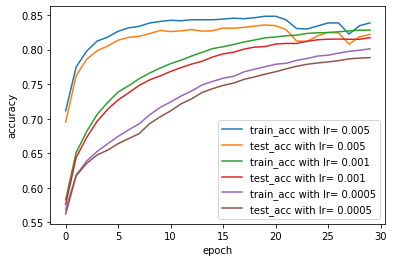

In [ ]:
for i in range(len(accs2_train_tanh)):
    plt.plot(np.array(accs2_train_tanh[i]),label= f'train_acc with lr= {tanh_lr_list[i]}')
    plt.plot(np.array(accs2_test_tanh[i]),label= f'test_acc with lr= {tanh_lr_list[i]}')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")

In [68]:
final_test_accs2_tanh=[]
final_train_accs2_tanh=[]
for i in range(len(accs2_test_tanh)):
  final_train_accs2_tanh.append(accs2_train_tanh[i][len(accs2_train_tanh[i])-1])
  final_test_accs2_tanh.append(accs2_test_tanh[i][len(accs2_test_tanh[i])-1])
print(final_train_accs2_tanh)
print(final_valid)
print(final_test_accs2_tanh)

[0.8518, 0.8268, 0.795]
[0.8485, 0.8305, 0.7985]
[0.83025, 0.809125, 0.779625]


# Unnormalized

In [77]:
(trainX_un, trainy_un), (testX_un, testy_un) = fashion_mnist.load_data()
vec_trainX_un= trainX_un.reshape((trainX_un.shape[0] ,trainX_un[0].shape[0]* trainX_un[0].shape[1]))
vec_testX_un= testX_un.reshape((testX_un.shape[0] ,testX_un[0].shape[0]* testX_un[0].shape[1]))
oh_trainy_un= np.zeros((len(trainy_un), 10))
oh_testy_un= np.zeros((len(testy_un), 10))
for idx, label in enumerate(trainy_un):
  oh_trainy_un[idx, label]= 1
for idx, label in enumerate(testy_un):
  oh_testy_un[idx, label]= 1
print(vec_trainX.shape)

(60000, 784)


In [78]:
vec_trainX_un = cp.asarray(vec_trainX_un)
vec_testX_un = cp.asarray(vec_testX_un)
trainy_un= cp.asarray(trainy_un)
testy_un= cp.asarray(testy_un)
oh_trainy_un=cp.asarray(oh_trainy_un)
oh_testy_un=cp.asarray(oh_testy_un)

In [79]:
validX_un= vec_testX_un[:2000]
validy_un= testy_un[:2000]
vec_testX_un= vec_testX_un[2000:]
testy_un= testy_un[2000:]

In [80]:
lr_list_un=[0.001,0.0005,0.0001]

In [81]:
with cp.cuda.Device(0):
    cp.random.seed(913)
    testX_s, testy_s = shuffle(vec_testX_un, testy_un)
    trainX_s, trainy_s = shuffle(vec_trainX_un, trainy_un)
    accs2_train_un=[]
    accs2_test_un=[]
    final_valid= []
    for i in range(len(lr_list_un)):
        train_acc_tmp=[]
        test_acc_tmp=[]
        mlp2_un = MLP()
        opt = GradientDescentOptimizer(mlp2_un,lr_list_un[i])
        train_acc_tmp, test_acc_tmp, loss = mlp2_un.fit(opt,trainX_s,trainy_s,testX_s,testy_s,32,30, evaluate=True)
        y_predicted = cp.argmax(mlp2_un.predict(validX_un), axis=-1)
        final_valid.append(eval_acc(y_predicted, validy_un))
        accs2_train_un.append(train_acc_tmp)
        accs2_test_un.append(test_acc_tmp)

Epoch 0


100%|██████████| 1875/1875 [00:03<00:00, 484.43it/s]


Epoch 1


100%|██████████| 1875/1875 [00:03<00:00, 503.73it/s]


Epoch 2


100%|██████████| 1875/1875 [00:03<00:00, 552.29it/s]


Epoch 3


100%|██████████| 1875/1875 [00:03<00:00, 559.21it/s]


Epoch 4


100%|██████████| 1875/1875 [00:03<00:00, 556.01it/s]


Epoch 5


100%|██████████| 1875/1875 [00:03<00:00, 560.97it/s]


Epoch 6


100%|██████████| 1875/1875 [00:03<00:00, 516.50it/s]


Epoch 7


100%|██████████| 1875/1875 [00:03<00:00, 525.46it/s]


Epoch 8


100%|██████████| 1875/1875 [00:03<00:00, 553.00it/s]


Epoch 9


100%|██████████| 1875/1875 [00:03<00:00, 516.61it/s]


Epoch 10


100%|██████████| 1875/1875 [00:03<00:00, 550.62it/s]


Epoch 11


100%|██████████| 1875/1875 [00:03<00:00, 527.64it/s]


Epoch 12


100%|██████████| 1875/1875 [00:03<00:00, 551.82it/s]


Epoch 13


100%|██████████| 1875/1875 [00:03<00:00, 553.19it/s]


Epoch 14


100%|██████████| 1875/1875 [00:03<00:00, 556.28it/s]


Epoch 15


100%|██████████| 1875/1875 [00:03<00:00, 562.44it/s]


Epoch 16


100%|██████████| 1875/1875 [00:03<00:00, 559.10it/s]


Epoch 17


100%|██████████| 1875/1875 [00:03<00:00, 521.60it/s]


Epoch 18


100%|██████████| 1875/1875 [00:03<00:00, 520.68it/s]


Epoch 19


100%|██████████| 1875/1875 [00:03<00:00, 551.32it/s]


Epoch 20


100%|██████████| 1875/1875 [00:03<00:00, 525.48it/s]


Epoch 21


100%|██████████| 1875/1875 [00:03<00:00, 555.17it/s]


Epoch 22


100%|██████████| 1875/1875 [00:03<00:00, 471.20it/s]


Epoch 23


100%|██████████| 1875/1875 [00:03<00:00, 557.55it/s]


Epoch 24


100%|██████████| 1875/1875 [00:03<00:00, 555.00it/s]


Epoch 25


100%|██████████| 1875/1875 [00:03<00:00, 563.82it/s]


Epoch 26


100%|██████████| 1875/1875 [00:03<00:00, 549.90it/s]


Epoch 27


100%|██████████| 1875/1875 [00:03<00:00, 516.33it/s]


Epoch 28


100%|██████████| 1875/1875 [00:03<00:00, 557.47it/s]


Epoch 29


100%|██████████| 1875/1875 [00:03<00:00, 520.09it/s]


Epoch 0


100%|██████████| 1875/1875 [00:03<00:00, 563.12it/s]


Epoch 1


100%|██████████| 1875/1875 [00:03<00:00, 524.06it/s]


Epoch 2


100%|██████████| 1875/1875 [00:03<00:00, 554.38it/s]


Epoch 3


100%|██████████| 1875/1875 [00:03<00:00, 528.00it/s]


Epoch 4


100%|██████████| 1875/1875 [00:03<00:00, 561.34it/s]


Epoch 5


100%|██████████| 1875/1875 [00:03<00:00, 549.58it/s]


Epoch 6


100%|██████████| 1875/1875 [00:03<00:00, 562.54it/s]


Epoch 7


100%|██████████| 1875/1875 [00:03<00:00, 548.65it/s]


Epoch 8


100%|██████████| 1875/1875 [00:03<00:00, 501.24it/s]


Epoch 9


100%|██████████| 1875/1875 [00:03<00:00, 550.10it/s]


Epoch 10


100%|██████████| 1875/1875 [00:03<00:00, 516.99it/s]


Epoch 11


100%|██████████| 1875/1875 [00:03<00:00, 560.79it/s]


Epoch 12


100%|██████████| 1875/1875 [00:03<00:00, 517.07it/s]


Epoch 13


100%|██████████| 1875/1875 [00:03<00:00, 502.25it/s]


Epoch 14


100%|██████████| 1875/1875 [00:03<00:00, 523.69it/s]


Epoch 15


100%|██████████| 1875/1875 [00:03<00:00, 561.36it/s]


Epoch 16


100%|██████████| 1875/1875 [00:03<00:00, 543.74it/s]


Epoch 17


100%|██████████| 1875/1875 [00:03<00:00, 563.37it/s]


Epoch 18


100%|██████████| 1875/1875 [00:03<00:00, 512.61it/s]


Epoch 19


100%|██████████| 1875/1875 [00:03<00:00, 552.33it/s]


Epoch 20


100%|██████████| 1875/1875 [00:03<00:00, 565.35it/s]


Epoch 21


100%|██████████| 1875/1875 [00:03<00:00, 531.30it/s]


Epoch 22


100%|██████████| 1875/1875 [00:03<00:00, 558.41it/s]


Epoch 23


100%|██████████| 1875/1875 [00:03<00:00, 518.01it/s]


Epoch 24


100%|██████████| 1875/1875 [00:03<00:00, 556.16it/s]


Epoch 25


100%|██████████| 1875/1875 [00:03<00:00, 531.04it/s]


Epoch 26


100%|██████████| 1875/1875 [00:03<00:00, 561.53it/s]


Epoch 27


100%|██████████| 1875/1875 [00:03<00:00, 526.61it/s]


Epoch 28


100%|██████████| 1875/1875 [00:03<00:00, 567.35it/s]


Epoch 29


100%|██████████| 1875/1875 [00:03<00:00, 499.08it/s]


Epoch 0


100%|██████████| 1875/1875 [00:03<00:00, 567.88it/s]


Epoch 1


100%|██████████| 1875/1875 [00:03<00:00, 557.96it/s]


Epoch 2


100%|██████████| 1875/1875 [00:03<00:00, 553.37it/s]


Epoch 3


100%|██████████| 1875/1875 [00:03<00:00, 557.73it/s]


Epoch 4


100%|██████████| 1875/1875 [00:04<00:00, 463.55it/s]


Epoch 5


100%|██████████| 1875/1875 [00:03<00:00, 564.74it/s]


Epoch 6


100%|██████████| 1875/1875 [00:03<00:00, 518.95it/s]


Epoch 7


100%|██████████| 1875/1875 [00:03<00:00, 556.03it/s]


Epoch 8


100%|██████████| 1875/1875 [00:03<00:00, 530.66it/s]


Epoch 9


100%|██████████| 1875/1875 [00:03<00:00, 529.98it/s]


Epoch 10


100%|██████████| 1875/1875 [00:03<00:00, 559.95it/s]


Epoch 11


100%|██████████| 1875/1875 [00:03<00:00, 564.56it/s]


Epoch 12


100%|██████████| 1875/1875 [00:03<00:00, 555.04it/s]


Epoch 13


100%|██████████| 1875/1875 [00:03<00:00, 557.42it/s]


Epoch 14


100%|██████████| 1875/1875 [00:03<00:00, 562.15it/s]


Epoch 15


100%|██████████| 1875/1875 [00:03<00:00, 525.51it/s]


Epoch 16


100%|██████████| 1875/1875 [00:03<00:00, 566.79it/s]


Epoch 17


100%|██████████| 1875/1875 [00:03<00:00, 522.48it/s]


Epoch 18


100%|██████████| 1875/1875 [00:03<00:00, 563.04it/s]


Epoch 19


100%|██████████| 1875/1875 [00:03<00:00, 523.09it/s]


Epoch 20


100%|██████████| 1875/1875 [00:03<00:00, 502.01it/s]


Epoch 21


100%|██████████| 1875/1875 [00:03<00:00, 544.34it/s]


Epoch 22


100%|██████████| 1875/1875 [00:03<00:00, 563.23it/s]


Epoch 23


100%|██████████| 1875/1875 [00:03<00:00, 562.54it/s]


Epoch 24


100%|██████████| 1875/1875 [00:03<00:00, 557.52it/s]


Epoch 25


100%|██████████| 1875/1875 [00:03<00:00, 502.92it/s]


Epoch 26


100%|██████████| 1875/1875 [00:03<00:00, 526.47it/s]


Epoch 27


100%|██████████| 1875/1875 [00:03<00:00, 556.64it/s]


Epoch 28


100%|██████████| 1875/1875 [00:03<00:00, 527.76it/s]


Epoch 29


100%|██████████| 1875/1875 [00:03<00:00, 562.07it/s]


Text(0, 0.5, 'accuracy')

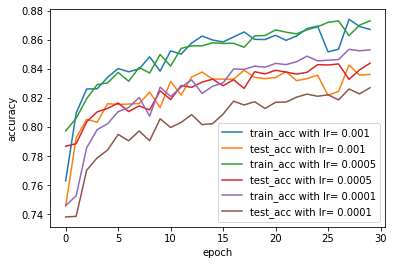

In [83]:
for i in range(len(accs2_train_un)):
    plt.plot(np.array(accs2_train_un[i]),label= f'train_acc with lr= {lr_list_un[i]}')
    plt.plot(np.array(accs2_test_un[i]),label= f'test_acc with lr= {lr_list_un[i]}')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")

In [82]:
final_test_accs2_un=[]
final_train_accs2_un=[]
for i in range(len(accs2_test_un)):
  final_train_accs2_un.append(accs2_train_un[i][len(accs2_train_un[i])-1])
  final_test_accs2_un.append(accs2_test_un[i][len(accs2_test_un[i])-1])
print(final_train_accs2_un)
print(final_valid)
print(final_test_accs2_un)

[0.8672166666666666, 0.8731833333333333, 0.8532]
[0.8575, 0.855, 0.835]
[0.83625, 0.844, 0.827125]


# ConvNet

In [29]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
def define_model(channel_size1,channel_size2,lr,str_coef):
  model = Sequential()
  model.add(Conv2D(channel_size1, (3, 3), activation='relu', input_shape=(28, 28, 1),strides=(str_coef)));
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(channel_size2, (3, 3), activation='relu',strides=(str_coef)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  # compile model
  opt = SGD(lr, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [30]:
cp.random.seed(2022)
trainX_s,oh_trainy_s=shuffle(cp.asarray(trainX),oh_trainy)
testX_s,oh_testy_s=shuffle(cp.asarray(testX),oh_testy)

trainX_s= trainX_s.get()
oh_trainy_s= oh_trainy_s.get()
testX_s= testX_s.get()
oh_testy_s= oh_testy_s.get()
# fitting the model
print(trainX.shape)
conv=[define_model(32,32,0.001,1),define_model(32,32,0.005,1),
      define_model(32,64,0.001,1),define_model(32,64,0.005,1),
      define_model(32,32,0.001,2),define_model(32,32,0.005,2),
      define_model(32,64,0.001,2),define_model(32,64,0.005,2)]
print(type(trainX_s), type(oh_trainy_s), type(testX_s), type(oh_testy_s))
for i in range(8):
  conv[i].fit(trainX_s, oh_trainy_s,batch_size = 32,epochs = 10,verbose = 1)
  print(i+1,"/8 complete")

# evaluating and printing results

(60000, 28, 28, 1)


2022-12-05 21:10:11.688903: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 21:10:11.695639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 21:10:11.696372: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-05 21:10:11.697719: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


2022-12-05 21:10:13.171977: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-12-05 21:10:14.451300: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


1875/1875 [==============================] - 12s 3ms/step - loss: 0.9919 - accuracy: 0.6465
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.5659 - accuracy: 0.7896
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4851 - accuracy: 0.8206
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4365 - accuracy: 0.8405
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4010 - accuracy: 0.8549
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3777 - accuracy: 0.8619
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3585 - accuracy: 0.8693
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3412 - accuracy: 0.8756
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3293 - accuracy: 0.8799
Epoch 10/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3181 - accura

In [51]:
cp.random.seed(2022)
trainX_s,oh_trainy_s=shuffle(cp.asarray(trainX),oh_trainy)
testX_s,oh_testy_s=shuffle(cp.asarray(testX),oh_testy)
validX_s,oh_validy_s=shuffle(cp.asarray(validX),oh_validy)             
trainX_s= trainX_s.get()
oh_trainy_s= oh_trainy_s.get()
testX_s= testX_s.get()
oh_testy_s= oh_testy_s.get()
validX_s= validX_s.get()
oh_validy_s= oh_validy_s.get()

print(trainX_s.shape, testX_s.shape, oh_testy_s.shape )
for i in range(8):
   scoretest= conv[i].evaluate(testX_s, oh_testy_s, verbose = 0)
   scoretrain= conv[i].evaluate(trainX_s, oh_trainy_s, verbose = 0)
   scorevalid= conv[i].evaluate(validX_s, oh_validy_s, verbose = 0)
   print('model',i+1,': Train loss:', scoretrain[0], 'Train accuracy:', scoretrain[1], 'Valid loss:', scorevalid[0], 'Valid accuracy:', scorevalid[1], 'Test loss:', scoretest[0], 'Test accuracy:', scoretest[1])


(60000, 28, 28, 1) (8000, 28, 28, 1) (8000, 10)
model 1 : Train loss: 0.31563735008239746 Train accuracy: 0.8825166821479797 Valid loss: 0.3455347716808319 Valid accuracy: 0.8759999871253967 Test loss: 0.3600929379463196 Test accuracy: 0.8657500147819519
model 2 : Train loss: 0.21157358586788177 Train accuracy: 0.919700026512146 Valid loss: 0.28581807017326355 Valid accuracy: 0.8934999704360962 Test loss: 0.29735568165779114 Test accuracy: 0.8932499885559082
model 3 : Train loss: 0.28265127539634705 Train accuracy: 0.8963000178337097 Valid loss: 0.31341293454170227 Valid accuracy: 0.8934999704360962 Test loss: 0.32620903849601746 Test accuracy: 0.8813750147819519
model 4 : Train loss: 0.176701158285141 Train accuracy: 0.9344666600227356 Valid loss: 0.25779980421066284 Valid accuracy: 0.909500002861023 Test loss: 0.2729071378707886 Test accuracy: 0.9028750061988831
model 5 : Train loss: 0.4597082734107971 Train accuracy: 0.833050012588501 Valid loss: 0.47967132925987244 Valid accuracy: 

In [52]:
cp.random.seed(2022)


trainX_s,oh_trainy_s=shuffle(cp.asarray(trainX),oh_trainy)
testX_s,oh_testy_s=shuffle(cp.asarray(testX),oh_testy)

trainX_s= trainX_s.get()
oh_trainy_s= oh_trainy_s.get()
testX_s= testX_s.get()
oh_testy_s= oh_testy_s.get()

accs=list()

# fitting the model
conv=define_model(32,64,0.005,1)

history= conv.fit(trainX_s, oh_trainy_s,batch_size = 32,epochs = 30,verbose = 1, shuffle=True, validation_data= (testX_s,oh_testy_s))


Epoch 1/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.6251 - accuracy: 0.7655 - val_loss: 0.4527 - val_accuracy: 0.8311
Epoch 2/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3844 - accuracy: 0.8570 - val_loss: 0.4061 - val_accuracy: 0.8533
Epoch 3/30
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3279 - accuracy: 0.8792 - val_loss: 0.3324 - val_accuracy: 0.8789
Epoch 4/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2928 - accuracy: 0.8927 - val_loss: 0.3064 - val_accuracy: 0.8907
Epoch 5/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2693 - accuracy: 0.9003 - val_loss: 0.3063 - val_accuracy: 0.8901
Epoch 6/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2504 - accuracy: 0.9057 - val_loss: 0.2856 - val_accuracy: 0.8953
Epoch 7/30
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2342 - accuracy: 0.9128 - val_loss: 0.2763 - val_accuracy:

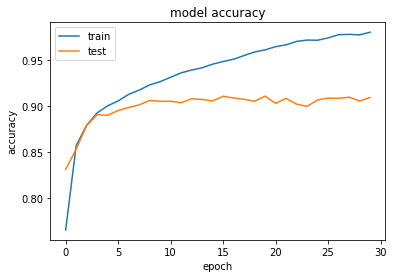

In [56]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Adam

In [87]:
lr_list_adam=[0.001,0.0005,0.0001]

In [100]:
validX.shape

(2000, 28, 28, 1)

In [103]:
with cp.cuda.Device(0):
    cp.random.seed(913)
    testX_s, testy_s = shuffle(vec_testX, testy)
    trainX_s, trainy_s = shuffle(vec_trainX, trainy)
    accs2_train_adam=[]
    accs2_test_adam=[]
    final_valid= []
    for i in range(len(lr_list_adam)):
        train_acc_tmp=[]
        test_acc_tmp=[]
        mlp2_adam = MLP()
        opt = Adam(mlp2_adam,lr_list_adam[i])
        train_acc_tmp, test_acc_tmp, loss = mlp2_adam.fit(opt,trainX_s,trainy_s,testX_s,testy_s,32,30, evaluate=True)
        y_predicted = cp.argmax(mlp2_adam.predict(validX_s), axis=-1)
        final_valid.append(eval_acc(y_predicted, validy_s))
        accs2_train_adam.append(train_acc_tmp)
        accs2_test_adam.append(test_acc_tmp)

Epoch 0


100%|██████████| 1875/1875 [00:06<00:00, 307.95it/s]


Epoch 1


100%|██████████| 1875/1875 [00:06<00:00, 298.16it/s]


Epoch 2


100%|██████████| 1875/1875 [00:06<00:00, 277.11it/s]


Epoch 3


100%|██████████| 1875/1875 [00:06<00:00, 302.01it/s]


Epoch 4


100%|██████████| 1875/1875 [00:06<00:00, 310.28it/s]


Epoch 5


100%|██████████| 1875/1875 [00:06<00:00, 304.86it/s]


Epoch 6


100%|██████████| 1875/1875 [00:06<00:00, 295.54it/s]


Epoch 7


100%|██████████| 1875/1875 [00:06<00:00, 295.17it/s]


Epoch 8


100%|██████████| 1875/1875 [00:06<00:00, 298.13it/s]


Epoch 9


100%|██████████| 1875/1875 [00:06<00:00, 289.59it/s]


Epoch 10


100%|██████████| 1875/1875 [00:06<00:00, 309.65it/s]


Epoch 11


100%|██████████| 1875/1875 [00:06<00:00, 296.68it/s]


Epoch 12


100%|██████████| 1875/1875 [00:06<00:00, 297.27it/s]


Epoch 13


100%|██████████| 1875/1875 [00:06<00:00, 298.97it/s]


Epoch 14


100%|██████████| 1875/1875 [00:06<00:00, 306.43it/s]


Epoch 15


100%|██████████| 1875/1875 [00:06<00:00, 305.84it/s]


Epoch 16


100%|██████████| 1875/1875 [00:06<00:00, 275.80it/s]


Epoch 17


100%|██████████| 1875/1875 [00:06<00:00, 299.07it/s]


Epoch 18


100%|██████████| 1875/1875 [00:06<00:00, 298.51it/s]


Epoch 19


100%|██████████| 1875/1875 [00:06<00:00, 308.62it/s]


Epoch 20


100%|██████████| 1875/1875 [00:06<00:00, 305.89it/s]


Epoch 21


100%|██████████| 1875/1875 [00:06<00:00, 296.96it/s]


Epoch 22


100%|██████████| 1875/1875 [00:06<00:00, 296.33it/s]


Epoch 23


100%|██████████| 1875/1875 [00:06<00:00, 277.91it/s]


Epoch 24


100%|██████████| 1875/1875 [00:06<00:00, 310.14it/s]


Epoch 25


100%|██████████| 1875/1875 [00:06<00:00, 305.76it/s]


Epoch 26


100%|██████████| 1875/1875 [00:06<00:00, 297.15it/s]


Epoch 27


100%|██████████| 1875/1875 [00:06<00:00, 279.39it/s]


Epoch 28


100%|██████████| 1875/1875 [00:06<00:00, 296.30it/s]


Epoch 29


100%|██████████| 1875/1875 [00:06<00:00, 308.82it/s]


Epoch 0


100%|██████████| 1875/1875 [00:06<00:00, 287.77it/s]


Epoch 1


100%|██████████| 1875/1875 [00:06<00:00, 292.91it/s]


Epoch 2


100%|██████████| 1875/1875 [00:06<00:00, 297.20it/s]


Epoch 3


100%|██████████| 1875/1875 [00:06<00:00, 297.00it/s]


Epoch 4


100%|██████████| 1875/1875 [00:06<00:00, 287.60it/s]


Epoch 5


100%|██████████| 1875/1875 [00:06<00:00, 307.95it/s]


Epoch 6


100%|██████████| 1875/1875 [00:06<00:00, 296.16it/s]


Epoch 7


100%|██████████| 1875/1875 [00:06<00:00, 291.61it/s]


Epoch 8


100%|██████████| 1875/1875 [00:06<00:00, 293.73it/s]


Epoch 9


100%|██████████| 1875/1875 [00:06<00:00, 308.20it/s]


Epoch 10


100%|██████████| 1875/1875 [00:06<00:00, 307.39it/s]


Epoch 11


100%|██████████| 1875/1875 [00:06<00:00, 279.17it/s]


Epoch 12


100%|██████████| 1875/1875 [00:06<00:00, 291.64it/s]


Epoch 13


100%|██████████| 1875/1875 [00:06<00:00, 290.88it/s]


Epoch 14


100%|██████████| 1875/1875 [00:06<00:00, 296.72it/s]


Epoch 15


100%|██████████| 1875/1875 [00:06<00:00, 304.99it/s]


Epoch 16


100%|██████████| 1875/1875 [00:06<00:00, 304.13it/s]


Epoch 17


100%|██████████| 1875/1875 [00:06<00:00, 294.90it/s]


Epoch 18


100%|██████████| 1875/1875 [00:06<00:00, 277.77it/s]


Epoch 19


100%|██████████| 1875/1875 [00:06<00:00, 287.37it/s]


Epoch 20


100%|██████████| 1875/1875 [00:06<00:00, 303.90it/s]


Epoch 21


100%|██████████| 1875/1875 [00:06<00:00, 302.94it/s]


Epoch 22


100%|██████████| 1875/1875 [00:06<00:00, 290.34it/s]


Epoch 23


100%|██████████| 1875/1875 [00:06<00:00, 291.52it/s]


Epoch 24


100%|██████████| 1875/1875 [00:06<00:00, 291.96it/s]


Epoch 25


100%|██████████| 1875/1875 [00:06<00:00, 283.65it/s]


Epoch 26


100%|██████████| 1875/1875 [00:06<00:00, 300.52it/s]


Epoch 27


100%|██████████| 1875/1875 [00:06<00:00, 300.95it/s]


Epoch 28


100%|██████████| 1875/1875 [00:06<00:00, 295.94it/s]


Epoch 29


100%|██████████| 1875/1875 [00:06<00:00, 295.13it/s]


Epoch 0


100%|██████████| 1875/1875 [00:06<00:00, 298.30it/s]


Epoch 1


100%|██████████| 1875/1875 [00:06<00:00, 306.88it/s]


Epoch 2


100%|██████████| 1875/1875 [00:06<00:00, 285.54it/s]


Epoch 3


100%|██████████| 1875/1875 [00:06<00:00, 293.27it/s]


Epoch 4


100%|██████████| 1875/1875 [00:06<00:00, 294.05it/s]


Epoch 5


100%|██████████| 1875/1875 [00:06<00:00, 295.68it/s]


Epoch 6


100%|██████████| 1875/1875 [00:06<00:00, 309.58it/s]


Epoch 7


100%|██████████| 1875/1875 [00:06<00:00, 309.01it/s]


Epoch 8


100%|██████████| 1875/1875 [00:06<00:00, 296.44it/s]


Epoch 9


100%|██████████| 1875/1875 [00:07<00:00, 267.81it/s]


Epoch 10


100%|██████████| 1875/1875 [00:06<00:00, 289.35it/s]


Epoch 11


100%|██████████| 1875/1875 [00:06<00:00, 305.14it/s]


Epoch 12


100%|██████████| 1875/1875 [00:06<00:00, 307.53it/s]


Epoch 13


100%|██████████| 1875/1875 [00:06<00:00, 288.41it/s]


Epoch 14


100%|██████████| 1875/1875 [00:06<00:00, 296.60it/s]


Epoch 15


100%|██████████| 1875/1875 [00:06<00:00, 296.23it/s]


Epoch 16


100%|██████████| 1875/1875 [00:06<00:00, 286.72it/s]


Epoch 17


100%|██████████| 1875/1875 [00:06<00:00, 306.36it/s]


Epoch 18


100%|██████████| 1875/1875 [00:06<00:00, 297.28it/s]


Epoch 19


100%|██████████| 1875/1875 [00:06<00:00, 296.74it/s]


Epoch 20


100%|██████████| 1875/1875 [00:06<00:00, 269.86it/s]


Epoch 21


100%|██████████| 1875/1875 [00:06<00:00, 307.38it/s]


Epoch 22


100%|██████████| 1875/1875 [00:06<00:00, 304.99it/s]


Epoch 23


100%|██████████| 1875/1875 [00:06<00:00, 284.07it/s]


Epoch 24


100%|██████████| 1875/1875 [00:06<00:00, 295.14it/s]


Epoch 25


100%|██████████| 1875/1875 [00:06<00:00, 297.14it/s]


Epoch 26


100%|██████████| 1875/1875 [00:06<00:00, 309.23it/s]


Epoch 27


100%|██████████| 1875/1875 [00:06<00:00, 285.07it/s]


Epoch 28


100%|██████████| 1875/1875 [00:06<00:00, 309.14it/s]


Epoch 29


100%|██████████| 1875/1875 [00:06<00:00, 295.45it/s]


Text(0, 0.5, 'accuracy')

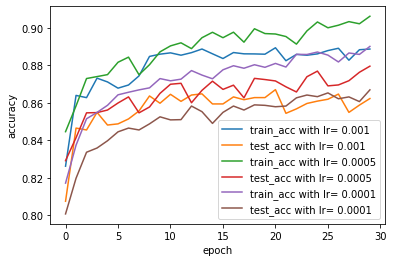

In [105]:
for i in range(len(accs2_train_adam)):
    plt.plot(np.array(accs2_train_adam[i]),label= f'train_acc with lr= {lr_list_adam[i]}')
    plt.plot(np.array(accs2_test_adam[i]),label= f'test_acc with lr= {lr_list_adam[i]}')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")

In [104]:
final_test_accs2_adam=[]
final_train_accs2_adam=[]
for i in range(len(accs2_test_adam)):
  final_train_accs2_adam.append(accs2_train_adam[i][len(accs2_train_adam[i])-1])
  final_test_accs2_adam.append(accs2_test_adam[i][len(accs2_test_adam[i])-1])
print(final_train_accs2_adam)
print(final_valid)
print(final_test_accs2_adam)

[0.8886333333333334, 0.9061166666666667, 0.8900333333333333]
[0.8675, 0.882, 0.884]
[0.86225, 0.8795, 0.866875]


# Best MLP architecture

In [23]:
first_lay=[32,64,128,256,512]
second_lay = [32,64,128,256,512]

In [30]:
with cp.cuda.Device(0):
    cp.random.seed(913)
    testX_s, testy_s = shuffle(vec_testX, testy)
    trainX_s, trainy_s = shuffle(vec_trainX, trainy)
    validX_s, validy_s = shuffle(vec_validX, validy)
    accs2_train_b=[]
    accs2_test_b=[]
    final_valid= []
    for i in range(len(first_lay)):
        train_acc_tmp=[]
        test_acc_tmp=[]
        mlp2_b = MLP(units=[first_lay[i],second_lay[i]])
        opt = GradientDescentOptimizer(mlp2_b,0.01)
        train_acc_tmp, test_acc_tmp, loss = mlp2_b.fit(opt,trainX_s,trainy_s,testX_s,testy_s,32,30, evaluate=True)
        y_predicted = cp.argmax(mlp2_b.predict(validX_s), axis=-1)
        final_valid.append(eval_acc(y_predicted, validy_s))
        accs2_train_b.append(train_acc_tmp)
        accs2_test_b.append(test_acc_tmp)

Epoch 0


100%|██████████| 1875/1875 [00:03<00:00, 498.73it/s]


Epoch 1


100%|██████████| 1875/1875 [00:03<00:00, 559.84it/s]


Epoch 2


100%|██████████| 1875/1875 [00:03<00:00, 571.14it/s]


Epoch 3


100%|██████████| 1875/1875 [00:03<00:00, 567.97it/s]


Epoch 4


100%|██████████| 1875/1875 [00:03<00:00, 559.68it/s]


Epoch 5


100%|██████████| 1875/1875 [00:03<00:00, 532.99it/s]


Epoch 6


100%|██████████| 1875/1875 [00:03<00:00, 562.42it/s]


Epoch 7


100%|██████████| 1875/1875 [00:03<00:00, 535.69it/s]


Epoch 8


100%|██████████| 1875/1875 [00:03<00:00, 563.79it/s]


Epoch 9


100%|██████████| 1875/1875 [00:03<00:00, 529.67it/s]


Epoch 10


100%|██████████| 1875/1875 [00:03<00:00, 504.15it/s]


Epoch 11


100%|██████████| 1875/1875 [00:03<00:00, 551.32it/s]


Epoch 12


100%|██████████| 1875/1875 [00:03<00:00, 563.56it/s]


Epoch 13


100%|██████████| 1875/1875 [00:03<00:00, 560.34it/s]


Epoch 14


100%|██████████| 1875/1875 [00:03<00:00, 569.39it/s]


Epoch 15


100%|██████████| 1875/1875 [00:03<00:00, 514.72it/s]


Epoch 16


100%|██████████| 1875/1875 [00:03<00:00, 562.94it/s]


Epoch 17


100%|██████████| 1875/1875 [00:03<00:00, 567.25it/s]


Epoch 18


100%|██████████| 1875/1875 [00:03<00:00, 528.42it/s]


Epoch 19


100%|██████████| 1875/1875 [00:03<00:00, 571.74it/s]


Epoch 20


100%|██████████| 1875/1875 [00:03<00:00, 529.98it/s]


Epoch 21


100%|██████████| 1875/1875 [00:03<00:00, 569.75it/s]


Epoch 22


100%|██████████| 1875/1875 [00:03<00:00, 536.71it/s]


Epoch 23


100%|██████████| 1875/1875 [00:03<00:00, 565.69it/s]


Epoch 24


100%|██████████| 1875/1875 [00:03<00:00, 538.33it/s]


Epoch 25


100%|██████████| 1875/1875 [00:03<00:00, 563.41it/s]


Epoch 26


100%|██████████| 1875/1875 [00:03<00:00, 487.09it/s]


Epoch 27


100%|██████████| 1875/1875 [00:03<00:00, 558.42it/s]


Epoch 28


100%|██████████| 1875/1875 [00:03<00:00, 538.49it/s]


Epoch 29


100%|██████████| 1875/1875 [00:03<00:00, 571.45it/s]


Epoch 0


100%|██████████| 1875/1875 [00:03<00:00, 562.23it/s]


Epoch 1


100%|██████████| 1875/1875 [00:04<00:00, 465.40it/s]


Epoch 2


100%|██████████| 1875/1875 [00:03<00:00, 568.65it/s]


Epoch 3


100%|██████████| 1875/1875 [00:03<00:00, 528.62it/s]


Epoch 4


100%|██████████| 1875/1875 [00:03<00:00, 568.17it/s]


Epoch 5


100%|██████████| 1875/1875 [00:03<00:00, 531.48it/s]


Epoch 6


100%|██████████| 1875/1875 [00:03<00:00, 566.73it/s]


Epoch 7


100%|██████████| 1875/1875 [00:03<00:00, 506.05it/s]


Epoch 8


100%|██████████| 1875/1875 [00:03<00:00, 562.38it/s]


Epoch 9


100%|██████████| 1875/1875 [00:03<00:00, 558.95it/s]


Epoch 10


100%|██████████| 1875/1875 [00:03<00:00, 553.46it/s]


Epoch 11


100%|██████████| 1875/1875 [00:03<00:00, 565.26it/s]


Epoch 12


100%|██████████| 1875/1875 [00:03<00:00, 501.49it/s]


Epoch 13


100%|██████████| 1875/1875 [00:03<00:00, 567.47it/s]


Epoch 14


100%|██████████| 1875/1875 [00:03<00:00, 531.58it/s]


Epoch 15


100%|██████████| 1875/1875 [00:03<00:00, 567.70it/s]


Epoch 16


100%|██████████| 1875/1875 [00:03<00:00, 531.47it/s]


Epoch 17


100%|██████████| 1875/1875 [00:03<00:00, 505.54it/s]


Epoch 18


100%|██████████| 1875/1875 [00:03<00:00, 533.37it/s]


Epoch 19


100%|██████████| 1875/1875 [00:03<00:00, 569.26it/s]


Epoch 20


100%|██████████| 1875/1875 [00:03<00:00, 529.65it/s]


Epoch 21


100%|██████████| 1875/1875 [00:03<00:00, 556.29it/s]


Epoch 22


100%|██████████| 1875/1875 [00:03<00:00, 567.75it/s]


Epoch 23


100%|██████████| 1875/1875 [00:03<00:00, 558.26it/s]


Epoch 24


100%|██████████| 1875/1875 [00:03<00:00, 561.70it/s]


Epoch 25


100%|██████████| 1875/1875 [00:03<00:00, 564.54it/s]


Epoch 26


100%|██████████| 1875/1875 [00:03<00:00, 567.27it/s]


Epoch 27


100%|██████████| 1875/1875 [00:03<00:00, 528.58it/s]


Epoch 28


100%|██████████| 1875/1875 [00:03<00:00, 535.92it/s]


Epoch 29


100%|██████████| 1875/1875 [00:03<00:00, 533.32it/s]


Epoch 0


100%|██████████| 1875/1875 [00:03<00:00, 564.19it/s]


Epoch 1


100%|██████████| 1875/1875 [00:03<00:00, 523.58it/s]


Epoch 2


100%|██████████| 1875/1875 [00:03<00:00, 564.58it/s]


Epoch 3


100%|██████████| 1875/1875 [00:03<00:00, 481.58it/s]


Epoch 4


100%|██████████| 1875/1875 [00:03<00:00, 564.58it/s]


Epoch 5


100%|██████████| 1875/1875 [00:03<00:00, 563.66it/s]


Epoch 6


100%|██████████| 1875/1875 [00:03<00:00, 558.05it/s]


Epoch 7


100%|██████████| 1875/1875 [00:03<00:00, 560.48it/s]


Epoch 8


100%|██████████| 1875/1875 [00:03<00:00, 489.57it/s]


Epoch 9


100%|██████████| 1875/1875 [00:03<00:00, 567.05it/s]


Epoch 10


100%|██████████| 1875/1875 [00:03<00:00, 526.80it/s]


Epoch 11


100%|██████████| 1875/1875 [00:03<00:00, 559.64it/s]


Epoch 12


100%|██████████| 1875/1875 [00:03<00:00, 530.66it/s]


Epoch 13


100%|██████████| 1875/1875 [00:03<00:00, 565.38it/s]


Epoch 14


100%|██████████| 1875/1875 [00:03<00:00, 512.14it/s]


Epoch 15


100%|██████████| 1875/1875 [00:03<00:00, 566.88it/s]


Epoch 16


100%|██████████| 1875/1875 [00:03<00:00, 561.16it/s]


Epoch 17


100%|██████████| 1875/1875 [00:03<00:00, 562.46it/s]


Epoch 18


100%|██████████| 1875/1875 [00:03<00:00, 566.95it/s]


Epoch 19


100%|██████████| 1875/1875 [00:03<00:00, 498.35it/s]


Epoch 20


100%|██████████| 1875/1875 [00:03<00:00, 558.52it/s]


Epoch 21


100%|██████████| 1875/1875 [00:03<00:00, 522.68it/s]


Epoch 22


100%|██████████| 1875/1875 [00:03<00:00, 565.25it/s]


Epoch 23


100%|██████████| 1875/1875 [00:03<00:00, 531.50it/s]


Epoch 24


100%|██████████| 1875/1875 [00:03<00:00, 509.25it/s]


Epoch 25


100%|██████████| 1875/1875 [00:03<00:00, 533.95it/s]


Epoch 26


100%|██████████| 1875/1875 [00:03<00:00, 559.28it/s]


Epoch 27


100%|██████████| 1875/1875 [00:03<00:00, 564.62it/s]


Epoch 28


100%|██████████| 1875/1875 [00:03<00:00, 567.47it/s]


Epoch 29


100%|██████████| 1875/1875 [00:03<00:00, 504.56it/s]


Epoch 0


100%|██████████| 1875/1875 [00:03<00:00, 532.52it/s]


Epoch 1


100%|██████████| 1875/1875 [00:03<00:00, 562.56it/s]


Epoch 2


100%|██████████| 1875/1875 [00:03<00:00, 526.73it/s]


Epoch 3


100%|██████████| 1875/1875 [00:03<00:00, 566.03it/s]


Epoch 4


100%|██████████| 1875/1875 [00:03<00:00, 522.12it/s]


Epoch 5


100%|██████████| 1875/1875 [00:03<00:00, 561.25it/s]


Epoch 6


100%|██████████| 1875/1875 [00:03<00:00, 539.47it/s]


Epoch 7


100%|██████████| 1875/1875 [00:03<00:00, 560.51it/s]


Epoch 8


100%|██████████| 1875/1875 [00:03<00:00, 564.95it/s]


Epoch 9


100%|██████████| 1875/1875 [00:03<00:00, 561.76it/s]


Epoch 10


100%|██████████| 1875/1875 [00:03<00:00, 537.57it/s]


Epoch 11


100%|██████████| 1875/1875 [00:03<00:00, 530.27it/s]


Epoch 12


100%|██████████| 1875/1875 [00:03<00:00, 566.79it/s]


Epoch 13


100%|██████████| 1875/1875 [00:03<00:00, 534.56it/s]


Epoch 14


100%|██████████| 1875/1875 [00:03<00:00, 566.54it/s]


Epoch 15


100%|██████████| 1875/1875 [00:04<00:00, 456.29it/s]


Epoch 16


100%|██████████| 1875/1875 [00:03<00:00, 566.64it/s]


Epoch 17


100%|██████████| 1875/1875 [00:03<00:00, 520.42it/s]


Epoch 18


100%|██████████| 1875/1875 [00:03<00:00, 561.16it/s]


Epoch 19


100%|██████████| 1875/1875 [00:03<00:00, 541.77it/s]


Epoch 20


100%|██████████| 1875/1875 [00:03<00:00, 514.81it/s]


Epoch 21


100%|██████████| 1875/1875 [00:03<00:00, 566.27it/s]


Epoch 22


100%|██████████| 1875/1875 [00:03<00:00, 528.09it/s]


Epoch 23


100%|██████████| 1875/1875 [00:03<00:00, 533.06it/s]


Epoch 24


100%|██████████| 1875/1875 [00:03<00:00, 531.61it/s]


Epoch 25


100%|██████████| 1875/1875 [00:03<00:00, 566.86it/s]


Epoch 26


100%|██████████| 1875/1875 [00:03<00:00, 532.44it/s]


Epoch 27


100%|██████████| 1875/1875 [00:03<00:00, 560.38it/s]


Epoch 28


100%|██████████| 1875/1875 [00:03<00:00, 559.60it/s]


Epoch 29


100%|██████████| 1875/1875 [00:03<00:00, 566.24it/s]


Epoch 0


100%|██████████| 1875/1875 [00:04<00:00, 411.39it/s]


Epoch 1


100%|██████████| 1875/1875 [00:04<00:00, 400.60it/s]


Epoch 2


100%|██████████| 1875/1875 [00:04<00:00, 411.43it/s]


Epoch 3


100%|██████████| 1875/1875 [00:04<00:00, 411.28it/s]


Epoch 4


100%|██████████| 1875/1875 [00:04<00:00, 400.34it/s]


Epoch 5


100%|██████████| 1875/1875 [00:04<00:00, 411.50it/s]


Epoch 6


100%|██████████| 1875/1875 [00:04<00:00, 410.98it/s]


Epoch 7


100%|██████████| 1875/1875 [00:04<00:00, 394.59it/s]


Epoch 8


100%|██████████| 1875/1875 [00:04<00:00, 410.99it/s]


Epoch 9


100%|██████████| 1875/1875 [00:04<00:00, 398.10it/s]


Epoch 10


100%|██████████| 1875/1875 [00:04<00:00, 404.12it/s]


Epoch 11


100%|██████████| 1875/1875 [00:04<00:00, 410.43it/s]


Epoch 12


100%|██████████| 1875/1875 [00:04<00:00, 410.06it/s]


Epoch 13


100%|██████████| 1875/1875 [00:04<00:00, 389.91it/s]


Epoch 14


100%|██████████| 1875/1875 [00:04<00:00, 410.87it/s]


Epoch 15


100%|██████████| 1875/1875 [00:04<00:00, 409.86it/s]


Epoch 16


100%|██████████| 1875/1875 [00:04<00:00, 402.33it/s]


Epoch 17


100%|██████████| 1875/1875 [00:04<00:00, 410.36it/s]


Epoch 18


100%|██████████| 1875/1875 [00:04<00:00, 410.13it/s]


Epoch 19


100%|██████████| 1875/1875 [00:04<00:00, 400.69it/s]


Epoch 20


100%|██████████| 1875/1875 [00:04<00:00, 405.77it/s]


Epoch 21


100%|██████████| 1875/1875 [00:04<00:00, 411.40it/s]


Epoch 22


100%|██████████| 1875/1875 [00:04<00:00, 397.72it/s]


Epoch 23


100%|██████████| 1875/1875 [00:04<00:00, 400.92it/s]


Epoch 24


100%|██████████| 1875/1875 [00:04<00:00, 411.77it/s]


Epoch 25


100%|██████████| 1875/1875 [00:04<00:00, 403.94it/s]


Epoch 26


100%|██████████| 1875/1875 [00:04<00:00, 390.84it/s]


Epoch 27


100%|██████████| 1875/1875 [00:04<00:00, 410.19it/s]


Epoch 28


100%|██████████| 1875/1875 [00:04<00:00, 400.58it/s]


Epoch 29


100%|██████████| 1875/1875 [00:04<00:00, 405.97it/s]


Text(0, 0.5, 'accuracy')

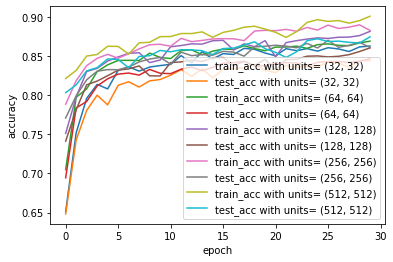

In [31]:
for i in range(len(first_lay)):
    plt.plot(np.array(accs2_train_b[i]),label= f'train_acc with units= {first_lay[i],second_lay[i]}')
    plt.plot(np.array(accs2_test_b[i]),label= f'test_acc with units= {first_lay[i],second_lay[i]}')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")

In [32]:
final_test_accs2_b=[]
final_train_accs2_b=[]
for i in range(len(accs2_test_b)):
  final_train_accs2_b.append(accs2_train_b[i][len(accs2_train_b[i])-1])
  final_test_accs2_b.append(accs2_test_b[i][len(accs2_test_b[i])-1])
print(final_train_accs2_b)
print(final_test_accs2_b)
print(final_valid)

[0.86265, 0.86885, 0.88135, 0.8825833333333334, 0.9006666666666666]
[0.844, 0.846625, 0.86025, 0.860625, 0.874375]
[0.859, 0.8645, 0.872, 0.868, 0.8845]


In [33]:
with cp.cuda.Device(0):
    cp.random.seed(913)
    testX_s, testy_s = shuffle(vec_testX, testy)
    trainX_s, trainy_s = shuffle(vec_trainX, trainy)
    validX_s, validy_s = shuffle(vec_validX, validy)
    accs1_train_b=[]
    accs1_test_b=[]
    final_valid= []
    for i in range(len(first_lay)):
        train_acc_tmp=[]
        test_acc_tmp=[]
        mlp1_b = MLP(units=[first_lay[i]],num_layers=1)
        opt = GradientDescentOptimizer(mlp1_b,0.01)
        train_acc_tmp, test_acc_tmp, loss = mlp1_b.fit(opt,trainX_s,trainy_s,testX_s,testy_s,32,30, evaluate=True)
        y_predicted = cp.argmax(mlp1_b.predict(validX_s), axis=-1)
        final_valid.append(eval_acc(y_predicted, validy_s))
        accs1_train_b.append(train_acc_tmp)
        accs1_test_b.append(test_acc_tmp)

Epoch 0


100%|██████████| 1875/1875 [00:02<00:00, 694.00it/s]


Epoch 1


100%|██████████| 1875/1875 [00:02<00:00, 756.90it/s]


Epoch 2


100%|██████████| 1875/1875 [00:02<00:00, 687.42it/s]


Epoch 3


100%|██████████| 1875/1875 [00:02<00:00, 667.90it/s]


Epoch 4


100%|██████████| 1875/1875 [00:02<00:00, 653.43it/s]


Epoch 5


100%|██████████| 1875/1875 [00:02<00:00, 659.68it/s]


Epoch 6


100%|██████████| 1875/1875 [00:02<00:00, 642.34it/s]


Epoch 7


100%|██████████| 1875/1875 [00:02<00:00, 775.71it/s]


Epoch 8


100%|██████████| 1875/1875 [00:02<00:00, 773.90it/s]


Epoch 9


100%|██████████| 1875/1875 [00:02<00:00, 774.75it/s]


Epoch 10


100%|██████████| 1875/1875 [00:02<00:00, 771.24it/s]


Epoch 11


100%|██████████| 1875/1875 [00:02<00:00, 775.24it/s]


Epoch 12


100%|██████████| 1875/1875 [00:02<00:00, 760.38it/s]


Epoch 13


100%|██████████| 1875/1875 [00:02<00:00, 722.90it/s]


Epoch 14


100%|██████████| 1875/1875 [00:02<00:00, 773.64it/s]


Epoch 15


100%|██████████| 1875/1875 [00:02<00:00, 695.61it/s]


Epoch 16


100%|██████████| 1875/1875 [00:02<00:00, 757.23it/s]


Epoch 17


100%|██████████| 1875/1875 [00:03<00:00, 614.33it/s]


Epoch 18


100%|██████████| 1875/1875 [00:02<00:00, 768.43it/s]


Epoch 19


100%|██████████| 1875/1875 [00:02<00:00, 651.74it/s]


Epoch 20


100%|██████████| 1875/1875 [00:02<00:00, 715.96it/s]


Epoch 21


100%|██████████| 1875/1875 [00:03<00:00, 616.43it/s]


Epoch 22


100%|██████████| 1875/1875 [00:02<00:00, 674.76it/s]


Epoch 23


100%|██████████| 1875/1875 [00:02<00:00, 711.48it/s]


Epoch 24


100%|██████████| 1875/1875 [00:02<00:00, 628.11it/s]


Epoch 25


100%|██████████| 1875/1875 [00:02<00:00, 687.02it/s]


Epoch 26


100%|██████████| 1875/1875 [00:02<00:00, 682.14it/s]


Epoch 27


100%|██████████| 1875/1875 [00:03<00:00, 624.41it/s]


Epoch 28


100%|██████████| 1875/1875 [00:02<00:00, 639.06it/s]


Epoch 29


100%|██████████| 1875/1875 [00:02<00:00, 631.57it/s]


Epoch 0


100%|██████████| 1875/1875 [00:02<00:00, 631.84it/s]


Epoch 1


100%|██████████| 1875/1875 [00:02<00:00, 659.94it/s]


Epoch 2


100%|██████████| 1875/1875 [00:02<00:00, 760.40it/s]


Epoch 3


100%|██████████| 1875/1875 [00:03<00:00, 589.62it/s]


Epoch 4


100%|██████████| 1875/1875 [00:02<00:00, 734.99it/s]


Epoch 5


100%|██████████| 1875/1875 [00:02<00:00, 690.84it/s]


Epoch 6


100%|██████████| 1875/1875 [00:03<00:00, 620.24it/s]


Epoch 7


100%|██████████| 1875/1875 [00:02<00:00, 729.59it/s]


Epoch 8


100%|██████████| 1875/1875 [00:02<00:00, 727.87it/s]


Epoch 9


100%|██████████| 1875/1875 [00:02<00:00, 734.92it/s]


Epoch 10


100%|██████████| 1875/1875 [00:02<00:00, 698.72it/s]


Epoch 11


100%|██████████| 1875/1875 [00:02<00:00, 663.74it/s]


Epoch 12


100%|██████████| 1875/1875 [00:02<00:00, 663.81it/s]


Epoch 13


100%|██████████| 1875/1875 [00:02<00:00, 721.90it/s]


Epoch 14


100%|██████████| 1875/1875 [00:02<00:00, 765.26it/s]


Epoch 15


100%|██████████| 1875/1875 [00:02<00:00, 767.21it/s]


Epoch 16


100%|██████████| 1875/1875 [00:02<00:00, 677.93it/s]


Epoch 17


100%|██████████| 1875/1875 [00:02<00:00, 743.92it/s]


Epoch 18


100%|██████████| 1875/1875 [00:03<00:00, 573.93it/s]


Epoch 19


100%|██████████| 1875/1875 [00:02<00:00, 752.08it/s]


Epoch 20


100%|██████████| 1875/1875 [00:02<00:00, 692.74it/s]


Epoch 21


100%|██████████| 1875/1875 [00:02<00:00, 763.91it/s]


Epoch 22


100%|██████████| 1875/1875 [00:02<00:00, 704.27it/s]


Epoch 23


100%|██████████| 1875/1875 [00:02<00:00, 761.09it/s]


Epoch 24


100%|██████████| 1875/1875 [00:03<00:00, 597.29it/s]


Epoch 25


100%|██████████| 1875/1875 [00:02<00:00, 763.27it/s]


Epoch 26


100%|██████████| 1875/1875 [00:02<00:00, 757.41it/s]


Epoch 27


100%|██████████| 1875/1875 [00:02<00:00, 756.65it/s]


Epoch 28


100%|██████████| 1875/1875 [00:02<00:00, 765.35it/s]


Epoch 29


100%|██████████| 1875/1875 [00:02<00:00, 766.00it/s]


Epoch 0


100%|██████████| 1875/1875 [00:02<00:00, 679.47it/s]


Epoch 1


100%|██████████| 1875/1875 [00:02<00:00, 758.62it/s]


Epoch 2


100%|██████████| 1875/1875 [00:02<00:00, 732.70it/s]


Epoch 3


100%|██████████| 1875/1875 [00:02<00:00, 693.14it/s]


Epoch 4


100%|██████████| 1875/1875 [00:02<00:00, 640.82it/s]


Epoch 5


100%|██████████| 1875/1875 [00:02<00:00, 705.21it/s]


Epoch 6


100%|██████████| 1875/1875 [00:03<00:00, 620.54it/s]


Epoch 7


100%|██████████| 1875/1875 [00:02<00:00, 647.27it/s]


Epoch 8


100%|██████████| 1875/1875 [00:02<00:00, 768.72it/s]


Epoch 9


 79%|███████▊  | 1472/1875 [00:02<00:00, 728.38it/s]


Epoch 0


100%|██████████| 1875/1875 [00:02<00:00, 766.63it/s]


Epoch 1


100%|██████████| 1875/1875 [00:02<00:00, 706.68it/s]


Epoch 2


100%|██████████| 1875/1875 [00:02<00:00, 646.06it/s]


Epoch 3


100%|██████████| 1875/1875 [00:02<00:00, 691.13it/s]


Epoch 4


100%|██████████| 1875/1875 [00:02<00:00, 765.36it/s]


Epoch 5


100%|██████████| 1875/1875 [00:02<00:00, 760.09it/s]


Epoch 6


100%|██████████| 1875/1875 [00:02<00:00, 748.19it/s]


Epoch 7


100%|██████████| 1875/1875 [00:02<00:00, 759.57it/s]


Epoch 8


100%|██████████| 1875/1875 [00:02<00:00, 646.55it/s]


Epoch 9


100%|██████████| 1875/1875 [00:02<00:00, 762.49it/s]


Epoch 10


100%|██████████| 1875/1875 [00:02<00:00, 746.97it/s]


Epoch 11


100%|██████████| 1875/1875 [00:02<00:00, 760.42it/s]


Epoch 12


100%|██████████| 1875/1875 [00:02<00:00, 743.75it/s]


Epoch 13


100%|██████████| 1875/1875 [00:02<00:00, 767.39it/s]


Epoch 14


100%|██████████| 1875/1875 [00:02<00:00, 673.35it/s]


Epoch 15


100%|██████████| 1875/1875 [00:02<00:00, 763.40it/s]


Epoch 16


100%|██████████| 1875/1875 [00:02<00:00, 700.38it/s]


Epoch 17


100%|██████████| 1875/1875 [00:02<00:00, 769.99it/s]


Epoch 18


100%|██████████| 1875/1875 [00:02<00:00, 693.23it/s]


Epoch 19


100%|██████████| 1875/1875 [00:02<00:00, 768.59it/s]


Epoch 20


100%|██████████| 1875/1875 [00:02<00:00, 759.87it/s]


Epoch 21


100%|██████████| 1875/1875 [00:02<00:00, 720.04it/s]


Epoch 22


100%|██████████| 1875/1875 [00:02<00:00, 753.25it/s]


Epoch 23


100%|██████████| 1875/1875 [00:02<00:00, 771.03it/s]


Epoch 24


100%|██████████| 1875/1875 [00:02<00:00, 760.29it/s]


Epoch 25


100%|██████████| 1875/1875 [00:02<00:00, 762.86it/s]


Epoch 26


100%|██████████| 1875/1875 [00:02<00:00, 758.98it/s]


Epoch 27


100%|██████████| 1875/1875 [00:02<00:00, 759.48it/s]


Epoch 28


100%|██████████| 1875/1875 [00:02<00:00, 757.95it/s]


Epoch 29


100%|██████████| 1875/1875 [00:02<00:00, 707.92it/s]


Epoch 0


100%|██████████| 1875/1875 [00:02<00:00, 625.87it/s]


Epoch 1


100%|██████████| 1875/1875 [00:03<00:00, 604.20it/s]


Epoch 2


100%|██████████| 1875/1875 [00:02<00:00, 626.58it/s]


Epoch 3


100%|██████████| 1875/1875 [00:03<00:00, 602.72it/s]


Epoch 4


100%|██████████| 1875/1875 [00:02<00:00, 627.51it/s]


Epoch 5


100%|██████████| 1875/1875 [00:03<00:00, 624.61it/s]


Epoch 6


100%|██████████| 1875/1875 [00:02<00:00, 627.37it/s]


Epoch 7


100%|██████████| 1875/1875 [00:02<00:00, 627.93it/s]


Epoch 8


100%|██████████| 1875/1875 [00:03<00:00, 589.58it/s]


Epoch 9


100%|██████████| 1875/1875 [00:02<00:00, 625.70it/s]


Epoch 10


100%|██████████| 1875/1875 [00:02<00:00, 626.63it/s]


Epoch 11


100%|██████████| 1875/1875 [00:03<00:00, 622.22it/s]


Epoch 12


100%|██████████| 1875/1875 [00:03<00:00, 623.19it/s]


Epoch 13


100%|██████████| 1875/1875 [00:02<00:00, 627.91it/s]


Epoch 14


100%|██████████| 1875/1875 [00:03<00:00, 606.34it/s]


Epoch 15


100%|██████████| 1875/1875 [00:02<00:00, 629.16it/s]


Epoch 16


100%|██████████| 1875/1875 [00:03<00:00, 608.21it/s]


Epoch 17


100%|██████████| 1875/1875 [00:02<00:00, 627.27it/s]


Epoch 18


100%|██████████| 1875/1875 [00:03<00:00, 596.04it/s]


Epoch 19


100%|██████████| 1875/1875 [00:03<00:00, 581.78it/s]


Epoch 20


100%|██████████| 1875/1875 [00:03<00:00, 602.19it/s]


Epoch 21


100%|██████████| 1875/1875 [00:02<00:00, 629.09it/s]


Epoch 22


100%|██████████| 1875/1875 [00:03<00:00, 603.84it/s]


Epoch 23


100%|██████████| 1875/1875 [00:02<00:00, 626.59it/s]


Epoch 24


100%|██████████| 1875/1875 [00:03<00:00, 598.12it/s]


Epoch 25


100%|██████████| 1875/1875 [00:03<00:00, 619.70it/s]


Epoch 26


100%|██████████| 1875/1875 [00:03<00:00, 598.16it/s]


Epoch 27


100%|██████████| 1875/1875 [00:03<00:00, 624.41it/s]


Epoch 28


100%|██████████| 1875/1875 [00:03<00:00, 604.11it/s]


Epoch 29


100%|██████████| 1875/1875 [00:02<00:00, 628.41it/s]


Text(0, 0.5, 'accuracy')

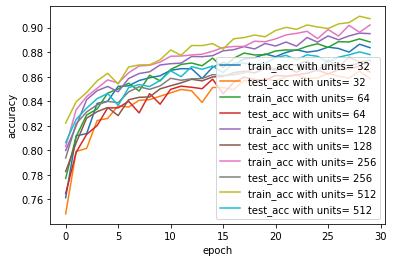

In [ ]:
for i in range(len(first_lay)):
    plt.plot(np.array(accs1_train_b[i]),label= f'train_acc with units= {first_lay[i]}')
    plt.plot(np.array(accs1_test_b[i]),label= f'test_acc with units= {first_lay[i]}')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")

In [34]:
final_test_accs1_b=[]
final_train_accs1_b=[]
for i in range(len(accs1_test_b)):
  final_train_accs1_b.append(accs1_train_b[i][len(accs1_train_b[i])-1])
  final_test_accs1_b.append(accs1_test_b[i][len(accs1_test_b[i])-1])
print(final_train_accs1_b)
print(final_test_accs1_b)
print(final_valid)

[0.8861666666666667, 0.89105, 0.8636833333333334, 0.89975, 0.9077]
[0.8605, 0.863375, 0.843375, 0.87075, 0.87325]
[0.8755, 0.8815, 0.8575, 0.8805, 0.8875]


In [35]:
cp.random.seed(913)
testX_s, testy_s = shuffle(vec_testX, testy)
trainX_s, trainy_s = shuffle(vec_trainX, trainy)
mlp1_b_adam = MLP(units=[512],num_layers=1)
opt = Adam(mlp1_b_adam,0.0005)
train_acc_tmp, test_acc_tmp, loss = mlp1_b_adam.fit(opt,trainX_s,trainy_s,testX_s,testy_s,32,30, evaluate=True)
y_predicted = cp.argmax(mlp1_b_adam.predict(validX_s), axis=-1)
final_valid= eval_acc(y_predicted, validy_s)

Epoch 0


100%|██████████| 1875/1875 [00:06<00:00, 307.44it/s]


Epoch 1


100%|██████████| 1875/1875 [00:04<00:00, 411.30it/s]


Epoch 2


100%|██████████| 1875/1875 [00:04<00:00, 431.42it/s]


Epoch 3


100%|██████████| 1875/1875 [00:04<00:00, 412.45it/s]


Epoch 4


100%|██████████| 1875/1875 [00:04<00:00, 429.26it/s]


Epoch 5


100%|██████████| 1875/1875 [00:04<00:00, 398.45it/s]


Epoch 6


100%|██████████| 1875/1875 [00:04<00:00, 404.96it/s]


Epoch 7


100%|██████████| 1875/1875 [00:04<00:00, 423.13it/s]


Epoch 8


100%|██████████| 1875/1875 [00:04<00:00, 426.80it/s]


Epoch 9


100%|██████████| 1875/1875 [00:04<00:00, 411.49it/s]


Epoch 10


100%|██████████| 1875/1875 [00:04<00:00, 431.95it/s]


Epoch 11


100%|██████████| 1875/1875 [00:04<00:00, 426.13it/s]


Epoch 12


100%|██████████| 1875/1875 [00:04<00:00, 412.49it/s]


Epoch 13


100%|██████████| 1875/1875 [00:04<00:00, 431.29it/s]


Epoch 14


100%|██████████| 1875/1875 [00:04<00:00, 393.38it/s]


Epoch 15


100%|██████████| 1875/1875 [00:04<00:00, 409.21it/s]


Epoch 16


100%|██████████| 1875/1875 [00:04<00:00, 428.59it/s]


Epoch 17


100%|██████████| 1875/1875 [00:04<00:00, 394.02it/s]


Epoch 18


100%|██████████| 1875/1875 [00:05<00:00, 365.28it/s]


Epoch 19


100%|██████████| 1875/1875 [00:04<00:00, 429.86it/s]


Epoch 20


100%|██████████| 1875/1875 [00:04<00:00, 411.35it/s]


Epoch 21


100%|██████████| 1875/1875 [00:04<00:00, 414.07it/s]


Epoch 22


100%|██████████| 1875/1875 [00:04<00:00, 431.75it/s]


Epoch 23


100%|██████████| 1875/1875 [00:04<00:00, 412.20it/s]


Epoch 24


100%|██████████| 1875/1875 [00:04<00:00, 426.70it/s]


Epoch 25


100%|██████████| 1875/1875 [00:04<00:00, 411.07it/s]


Epoch 26


100%|██████████| 1875/1875 [00:04<00:00, 405.97it/s]


Epoch 27


100%|██████████| 1875/1875 [00:04<00:00, 383.48it/s]


Epoch 28


100%|██████████| 1875/1875 [00:04<00:00, 428.00it/s]


Epoch 29


100%|██████████| 1875/1875 [00:04<00:00, 403.27it/s]


In [36]:
train_acc_tmp[29], final_valid, test_acc_tmp[29]

(0.9668166666666667, 0.898, 0.890875)

In [37]:
cp.random.seed(913)
testX_s, testy_s = shuffle(vec_testX, testy)
trainX_s, trainy_s = shuffle(vec_trainX, trainy)
mlp2_b_adam = MLP(units=[512,512])
opt = Adam(mlp2_b_adam,0.0005)
train_acc_tmp2, test_acc_tmp2, loss2 = mlp2_b_adam.fit(opt,trainX_s,trainy_s,testX_s,testy_s,32,30, evaluate=True)
y_predicted = cp.argmax(mlp2_b_adam.predict(validX_s), axis=-1)
final_valid= eval_acc(y_predicted, validy_s)

Epoch 0


100%|██████████| 1875/1875 [00:06<00:00, 303.36it/s]


Epoch 1


100%|██████████| 1875/1875 [00:06<00:00, 306.99it/s]


Epoch 2


100%|██████████| 1875/1875 [00:06<00:00, 271.90it/s]


Epoch 3


100%|██████████| 1875/1875 [00:06<00:00, 291.07it/s]


Epoch 4


100%|██████████| 1875/1875 [00:06<00:00, 295.38it/s]


Epoch 5


100%|██████████| 1875/1875 [00:06<00:00, 295.06it/s]


Epoch 6


100%|██████████| 1875/1875 [00:06<00:00, 303.89it/s]


Epoch 7


100%|██████████| 1875/1875 [00:06<00:00, 306.90it/s]


Epoch 8


100%|██████████| 1875/1875 [00:06<00:00, 295.12it/s]


Epoch 9


100%|██████████| 1875/1875 [00:06<00:00, 273.55it/s]


Epoch 10


100%|██████████| 1875/1875 [00:06<00:00, 296.90it/s]


Epoch 11


100%|██████████| 1875/1875 [00:06<00:00, 294.67it/s]


Epoch 12


100%|██████████| 1875/1875 [00:06<00:00, 303.04it/s]


Epoch 13


100%|██████████| 1875/1875 [00:06<00:00, 305.90it/s]


Epoch 14


100%|██████████| 1875/1875 [00:06<00:00, 296.41it/s]


Epoch 15


100%|██████████| 1875/1875 [00:06<00:00, 296.07it/s]


Epoch 16


100%|██████████| 1875/1875 [00:06<00:00, 274.55it/s]


Epoch 17


100%|██████████| 1875/1875 [00:06<00:00, 304.20it/s]


Epoch 18


100%|██████████| 1875/1875 [00:06<00:00, 306.83it/s]


Epoch 19


100%|██████████| 1875/1875 [00:06<00:00, 297.53it/s]


Epoch 20


100%|██████████| 1875/1875 [00:06<00:00, 289.72it/s]


Epoch 21


100%|██████████| 1875/1875 [00:06<00:00, 292.52it/s]


Epoch 22


100%|██████████| 1875/1875 [00:06<00:00, 295.67it/s]


Epoch 23


100%|██████████| 1875/1875 [00:06<00:00, 281.75it/s]


Epoch 24


100%|██████████| 1875/1875 [00:06<00:00, 305.41it/s]


Epoch 25


100%|██████████| 1875/1875 [00:06<00:00, 305.67it/s]


Epoch 26


100%|██████████| 1875/1875 [00:06<00:00, 275.33it/s]


Epoch 27


100%|██████████| 1875/1875 [00:06<00:00, 295.70it/s]


Epoch 28


100%|██████████| 1875/1875 [00:06<00:00, 293.31it/s]


Epoch 29


100%|██████████| 1875/1875 [00:06<00:00, 304.87it/s]


In [38]:
train_acc_tmp2[29], final_valid, test_acc_tmp2[29]

(0.8959166666666667, 0.872, 0.867625)

In [40]:
cp.random.seed(913)
testX_s, testy_s = shuffle(vec_testX, testy)
trainX_s, trainy_s = shuffle(vec_trainX, trainy)
mlp1_b_adam_r = MLP(units=[512],num_layers=1,regularization=0.000001)
opt = Adam(mlp1_b_adam_r,0.0005)
train_acc_tmp_r, test_acc_tmp_r, loss = mlp1_b_adam_r.fit(opt,trainX_s,trainy_s,testX_s,testy_s,32,30, evaluate=True)
y_predicted = cp.argmax(mlp1_b_adam_r.predict(validX_s), axis=-1)
final_valid= eval_acc(y_predicted, validy_s)

Epoch 0


100%|██████████| 1875/1875 [00:04<00:00, 412.14it/s]


Epoch 1


100%|██████████| 1875/1875 [00:04<00:00, 408.18it/s]


Epoch 2


100%|██████████| 1875/1875 [00:04<00:00, 426.79it/s]


Epoch 3


100%|██████████| 1875/1875 [00:04<00:00, 411.76it/s]


Epoch 4


100%|██████████| 1875/1875 [00:04<00:00, 426.75it/s]


Epoch 5


100%|██████████| 1875/1875 [00:04<00:00, 433.62it/s]


Epoch 6


100%|██████████| 1875/1875 [00:04<00:00, 412.76it/s]


Epoch 7


100%|██████████| 1875/1875 [00:04<00:00, 432.33it/s]


Epoch 8


100%|██████████| 1875/1875 [00:04<00:00, 399.93it/s]


Epoch 9


100%|██████████| 1875/1875 [00:04<00:00, 411.16it/s]


Epoch 10


100%|██████████| 1875/1875 [00:04<00:00, 431.43it/s]


Epoch 11


100%|██████████| 1875/1875 [00:04<00:00, 431.37it/s]


Epoch 12


100%|██████████| 1875/1875 [00:04<00:00, 409.09it/s]


Epoch 13


100%|██████████| 1875/1875 [00:04<00:00, 425.23it/s]


Epoch 14


100%|██████████| 1875/1875 [00:04<00:00, 433.00it/s]


Epoch 15


100%|██████████| 1875/1875 [00:04<00:00, 410.65it/s]


Epoch 16


100%|██████████| 1875/1875 [00:04<00:00, 433.44it/s]


Epoch 17


100%|██████████| 1875/1875 [00:04<00:00, 379.34it/s]


Epoch 18


100%|██████████| 1875/1875 [00:04<00:00, 415.29it/s]


Epoch 19


 30%|███       | 568/1875 [00:01<00:03, 434.14it/s]


In [42]:
train_acc_tmp_r[-1], final_valid, test_acc_tmp_r[-1]

(0.95365, 0.9025, 0.896375)

In [50]:
cp.random.seed(913)
testX_s, testy_s = shuffle(vec_testX, testy)
trainX_s, trainy_s = shuffle(vec_trainX, trainy)
mlp1_b_adam_r = MLP(units=[512, 512],num_layers=2,regularization=0.000001)
opt = Adam(mlp1_b_adam_r,0.0005)
train_acc_tmp_r, test_acc_tmp_r, loss = mlp1_b_adam_r.fit(opt,trainX_s,trainy_s,testX_s,testy_s,32,50, evaluate=True)
y_predicted = cp.argmax(mlp1_b_adam_r.predict(validX_s), axis=-1)
final_valid= eval_acc(y_predicted, validy_s)

Epoch 0


100%|██████████| 1875/1875 [00:06<00:00, 304.76it/s]


Epoch 1


100%|██████████| 1875/1875 [00:06<00:00, 280.82it/s]


Epoch 2


100%|██████████| 1875/1875 [00:06<00:00, 298.61it/s]


Epoch 3


100%|██████████| 1875/1875 [00:06<00:00, 295.71it/s]


Epoch 4


100%|██████████| 1875/1875 [00:06<00:00, 294.37it/s]


Epoch 5


100%|██████████| 1875/1875 [00:06<00:00, 304.75it/s]


Epoch 6


100%|██████████| 1875/1875 [00:06<00:00, 301.50it/s]


Epoch 7


100%|██████████| 1875/1875 [00:06<00:00, 297.77it/s]


Epoch 8


100%|██████████| 1875/1875 [00:06<00:00, 275.05it/s]


Epoch 9


100%|██████████| 1875/1875 [00:06<00:00, 296.37it/s]


Epoch 10


100%|██████████| 1875/1875 [00:06<00:00, 309.61it/s]


Epoch 11


100%|██████████| 1875/1875 [00:06<00:00, 289.04it/s]


Epoch 12


100%|██████████| 1875/1875 [00:06<00:00, 293.92it/s]


Epoch 13


100%|██████████| 1875/1875 [00:06<00:00, 294.94it/s]


Epoch 14


100%|██████████| 1875/1875 [00:06<00:00, 299.33it/s]


Epoch 15


100%|██████████| 1875/1875 [00:06<00:00, 278.87it/s]


Epoch 16


100%|██████████| 1875/1875 [00:06<00:00, 310.66it/s]


Epoch 17


100%|██████████| 1875/1875 [00:06<00:00, 308.20it/s]


Epoch 18


100%|██████████| 1875/1875 [00:06<00:00, 280.10it/s]


Epoch 19


100%|██████████| 1875/1875 [00:06<00:00, 287.86it/s]


Epoch 20


100%|██████████| 1875/1875 [00:06<00:00, 297.73it/s]


Epoch 21


100%|██████████| 1875/1875 [00:06<00:00, 307.87it/s]


Epoch 22


100%|██████████| 1875/1875 [00:06<00:00, 287.32it/s]


Epoch 23


100%|██████████| 1875/1875 [00:06<00:00, 309.71it/s]


Epoch 24


100%|██████████| 1875/1875 [00:06<00:00, 299.50it/s]


Epoch 25


100%|██████████| 1875/1875 [00:06<00:00, 278.13it/s]


Epoch 26


100%|██████████| 1875/1875 [00:06<00:00, 296.94it/s]


Epoch 27


100%|██████████| 1875/1875 [00:06<00:00, 309.92it/s]


Epoch 28


100%|██████████| 1875/1875 [00:06<00:00, 310.19it/s]


Epoch 29


100%|██████████| 1875/1875 [00:06<00:00, 278.66it/s]


Epoch 30


100%|██████████| 1875/1875 [00:06<00:00, 297.09it/s]


Epoch 31


100%|██████████| 1875/1875 [00:06<00:00, 296.41it/s]


Epoch 32


100%|██████████| 1875/1875 [00:06<00:00, 288.99it/s]


Epoch 33


100%|██████████| 1875/1875 [00:06<00:00, 301.58it/s]


Epoch 34


100%|██████████| 1875/1875 [00:06<00:00, 309.76it/s]


Epoch 35


100%|██████████| 1875/1875 [00:06<00:00, 298.79it/s]


Epoch 36


100%|██████████| 1875/1875 [00:06<00:00, 289.27it/s]


Epoch 37


100%|██████████| 1875/1875 [00:06<00:00, 299.41it/s]


Epoch 38


100%|██████████| 1875/1875 [00:06<00:00, 306.45it/s]


Epoch 39


100%|██████████| 1875/1875 [00:06<00:00, 287.94it/s]


Epoch 40


100%|██████████| 1875/1875 [00:06<00:00, 297.98it/s]


Epoch 41


100%|██████████| 1875/1875 [00:06<00:00, 299.95it/s]


Epoch 42


100%|██████████| 1875/1875 [00:06<00:00, 296.04it/s]


Epoch 43


100%|██████████| 1875/1875 [00:06<00:00, 302.75it/s]


Epoch 44


100%|██████████| 1875/1875 [00:06<00:00, 309.69it/s]


Epoch 45


100%|██████████| 1875/1875 [00:06<00:00, 305.46it/s]


Epoch 46


100%|██████████| 1875/1875 [00:07<00:00, 265.64it/s]


Epoch 47


100%|██████████| 1875/1875 [00:06<00:00, 295.95it/s]


Epoch 48


100%|██████████| 1875/1875 [00:06<00:00, 295.85it/s]


Epoch 49


100%|██████████| 1875/1875 [00:06<00:00, 306.21it/s]


In [51]:
train_acc_tmp_r[49], final_valid, test_acc_tmp_r[49]

(0.9139, 0.887, 0.8795)